AIN311 CLASS PROJECT

MELİKE NUR DULKADİR & SARE NAZ ERSOY

# Career Path Predictor

Importing necessary libraries

In [137]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [138]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import tree,svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
sns.set(style="white")
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
import matplotlib.pyplot as plt

In [139]:
df = pd.read_csv('https://raw.githubusercontent.com/sayalideo/Job-Role-Prediction-/master/Data/roo_data.csv')
df.head()

,Acedamic percentage in Operating Systems,percentage in Algorithms,Percentage in Programming Concepts,Percentage in Software Engineering,Percentage in Computer Networks,Percentage in Electronics Subjects,Percentage in Computer Architecture,Percentage in Mathematics,Percentage in Communication skills,Hours working per day,...,Interested Type of Books,Salary Range Expected,In a Realtionship?,Gentle or Tuff behaviour?,Management or Technical,Salary/work,hard/smart worker,worked in teams ever?,Introvert,Suggested Job Role
0,69,63,78,87,94,94,87,84,61,9,...,Prayer books,salary,no,stubborn,Management,salary,hard worker,yes,no,Database Administrator
1,78,62,73,60,71,70,73,84,91,12,...,Childrens,salary,yes,gentle,Technical,salary,hard worker,no,yes,Project Manager
2,71,86,91,87,61,81,72,72,94,11,...,Travel,Work,no,stubborn,Management,work,hard worker,no,yes,Project Manager
3,76,87,60,84,89,73,62,88,69,7,...,Romance,Work,yes,gentle,Management,work,smart worker,yes,yes,Security Administrator
4,92,62,90,67,71,89,73,71,73,4,...,Cookbooks,salary,no,stubborn,Management,work,hard worker,yes,yes,Business Intelligence Analyst


Some utils functions for understand the data clearly

In [140]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    print("##################### Properties #####################")
    print(df.describe())

In [141]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Returns the names of categorical, numeric and categorical but cardinal variables in the data set.
    Note: Categorical variables with numerical appearance are also included in categorical variables.

    Parameters
    ------
        dataframe: dataframe
                The dataframe from which variable names are to be retrieved
        cat_th: int, optional
                Class threshold for numeric but categorical variables
        car_th: int, optinal
                Class threshold for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numeric variable list
        cat_but_car: list
                Categorical view cardinal variable list

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        num_but_cat inside cat_cols.
        The sum of the 3 returned lists equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables
    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    #num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th anddataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    #cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    #num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
   # print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [142]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [143]:
def replace_with_thresholds(dataframe, variable, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1, q3)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [144]:
def check_outlier(dataframe, col_name, q1=.25, q3=.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [145]:
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)
    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

In [146]:
def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

In [147]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.90):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list

In [148]:
def plot_importance(model, features, save=False):

    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(20, 20))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:len(features)])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

In [149]:
check_df(df)

##################### Shape #####################
(20000, 39)
##################### Types #####################
Acedamic percentage in Operating Systems     int64
percentage in Algorithms                     int64
Percentage in Programming Concepts           int64
Percentage in Software Engineering           int64
Percentage in Computer Networks              int64
Percentage in Electronics Subjects           int64
Percentage in Computer Architecture          int64
Percentage in Mathematics                    int64
Percentage in Communication skills           int64
Hours working per day                        int64
Logical quotient rating                      int64
hackathons                                   int64
coding skills rating                         int64
public speaking points                       int64
can work long time before system?           object
self-learning capability?                   object
Extra-courses did                           object
certifications       

In [150]:
df.columns = ['Academic_Percentage_In_Operating_Systems', 'Algorithms_Percentage',
              'Programming_Concepts_Percentage',
              'Software_Engineering_Percentage', 'Computer_Networks_Percentage',
              'Electronics_Subjects_Percentage',
              'Computer_Architecture_Percentage', 'Mathematics_Percentage',
              'Communication_Skills_Percentage', 'Hours_Working_Per_Day',
              'Logical_Quotient_Rating', 'Hackathons', 'Coding_Skills_Rating',
              'Public_Speaking_Points', 'Can_Work_Long_Time_Before_System',
              'Self_Learning_Capability', 'Extra_Courses_Did', 'Certifications',
              'Workshops', 'Talent_Tests_Taken', 'Olympiads',
              'Reading_And_Writing_Skills', 'Memory_Capability_Score',
              'Interested_Subjects', 'Interested_Career_Area', 'Job/Higher_Studies',
              'Type_Of_Company_Want_To_Settle_In',
              'Taken_Inputs_From_Seniors_Or_Elders', 'Interested_In_Games',
              'Interested_Type_Of_Books', 'Salary_or_Work',
              'Being_In_A_Relationship', 'Gentle_Or_Tuff_Behaviour',
              'Management_Or_Technical', 'Salary/Work', 'Worker_Type',
              'Worked_In_Teams_Ever', 'Introvert', 'Suggested_Job_Role']

In [151]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 20000
Variables: 39
cat_cols: 24
num_cols: 14
cat_but_car: 1


In [152]:
num_cols

['Academic_Percentage_In_Operating_Systems',
 'Algorithms_Percentage',
 'Programming_Concepts_Percentage',
 'Software_Engineering_Percentage',
 'Computer_Networks_Percentage',
 'Electronics_Subjects_Percentage',
 'Computer_Architecture_Percentage',
 'Mathematics_Percentage',
 'Communication_Skills_Percentage',
 'Hours_Working_Per_Day',
 'Logical_Quotient_Rating',
 'Hackathons',
 'Coding_Skills_Rating',
 'Public_Speaking_Points']

In [153]:
for col in num_cols:
    print(check_outlier(df,col))

False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [154]:
scaler = StandardScaler()
cols_to_scale = num_cols

#create and fit scaler
scaler.fit(df[cols_to_scale])

#scale selected data
df[cols_to_scale] = scaler.transform(df[cols_to_scale])


<AxesSubplot: >

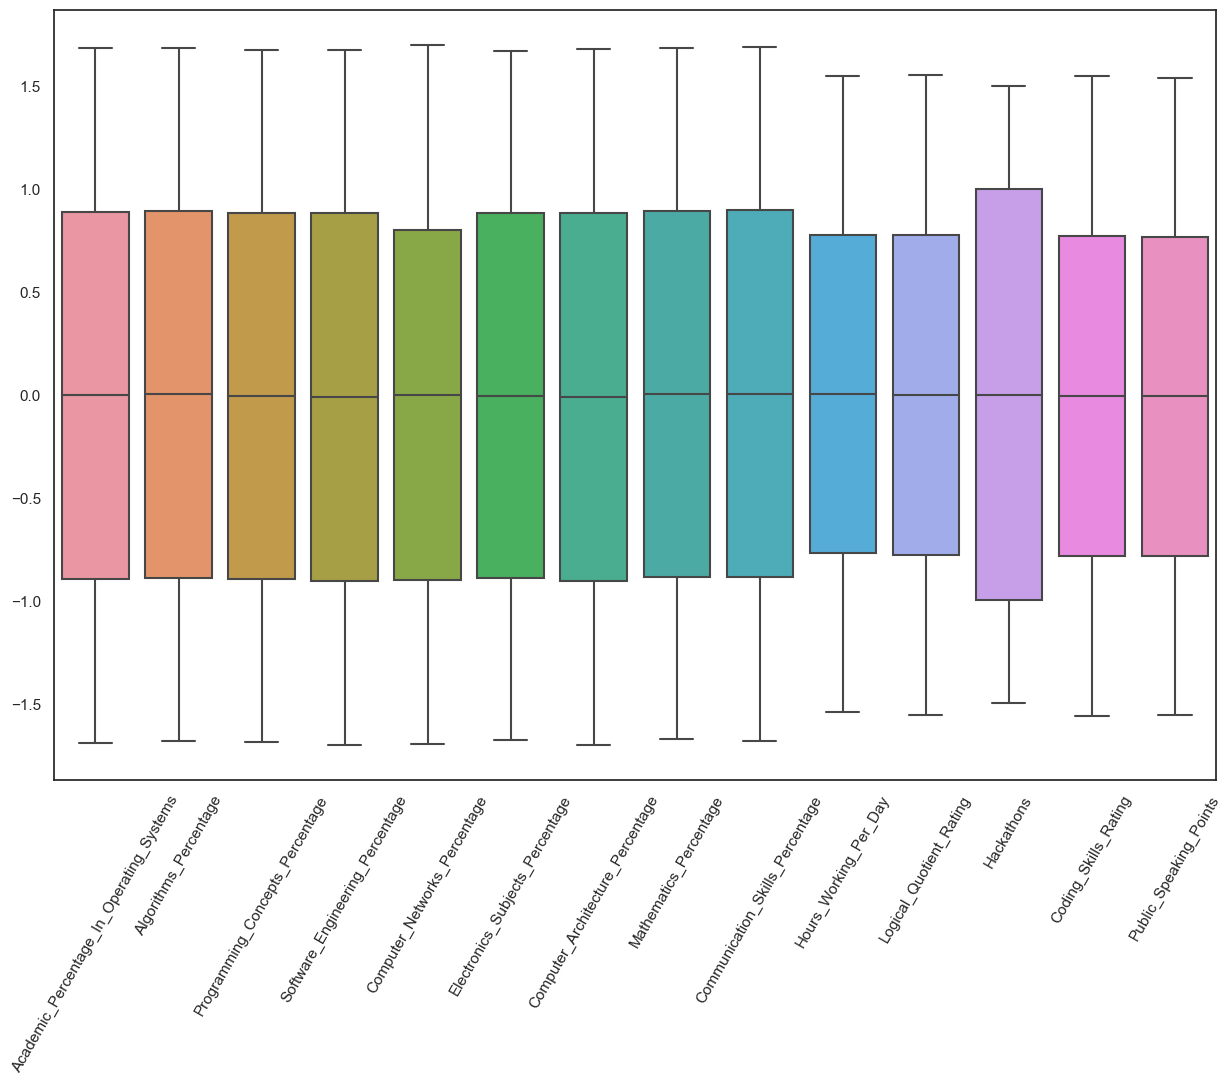

In [155]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
sns.boxplot(data=df[num_cols], ax=ax)

In [156]:
print("\n######## List of Categorical features ########\n")
for index,col in enumerate(cat_cols):
    print(index,col)


######## List of Categorical features ########

0 Can_Work_Long_Time_Before_System
1 Self_Learning_Capability
2 Extra_Courses_Did
3 Certifications
4 Workshops
5 Talent_Tests_Taken
6 Olympiads
7 Reading_And_Writing_Skills
8 Memory_Capability_Score
9 Interested_Subjects
10 Interested_Career_Area
11 Job/Higher_Studies
12 Type_Of_Company_Want_To_Settle_In
13 Taken_Inputs_From_Seniors_Or_Elders
14 Interested_In_Games
15 Salary_or_Work
16 Being_In_A_Relationship
17 Gentle_Or_Tuff_Behaviour
18 Management_Or_Technical
19 Salary/Work
20 Worker_Type
21 Worked_In_Teams_Ever
22 Introvert
23 Suggested_Job_Role


In [157]:
for i in cat_cols:
    print(df[i].value_counts(), end="\n\n")

yes    10020
no      9980
Name: Can_Work_Long_Time_Before_System, dtype: int64

yes    10102
no      9898
Name: Self_Learning_Capability, dtype: int64

no     10049
yes     9951
Name: Extra_Courses_Did, dtype: int64

r programming           2275
machine learning        2255
shell programming       2252
information security    2250
full stack              2239
hadoop                  2210
python                  2198
app development         2165
distro making           2156
Name: Certifications, dtype: int64

web technologies     2586
data science         2551
game development     2522
database security    2517
system designing     2516
hacking              2473
testing              2444
cloud computing      2391
Name: Workshops, dtype: int64

yes    10047
no      9953
Name: Talent_Tests_Taken, dtype: int64

yes    10079
no      9921
Name: Olympiads, dtype: int64

excellent    6696
poor         6683
medium       6621
Name: Reading_And_Writing_Skills, dtype: int64

poor         6677
exce

### Correlations of Features and Dimensionality Reduction

<AxesSubplot: >

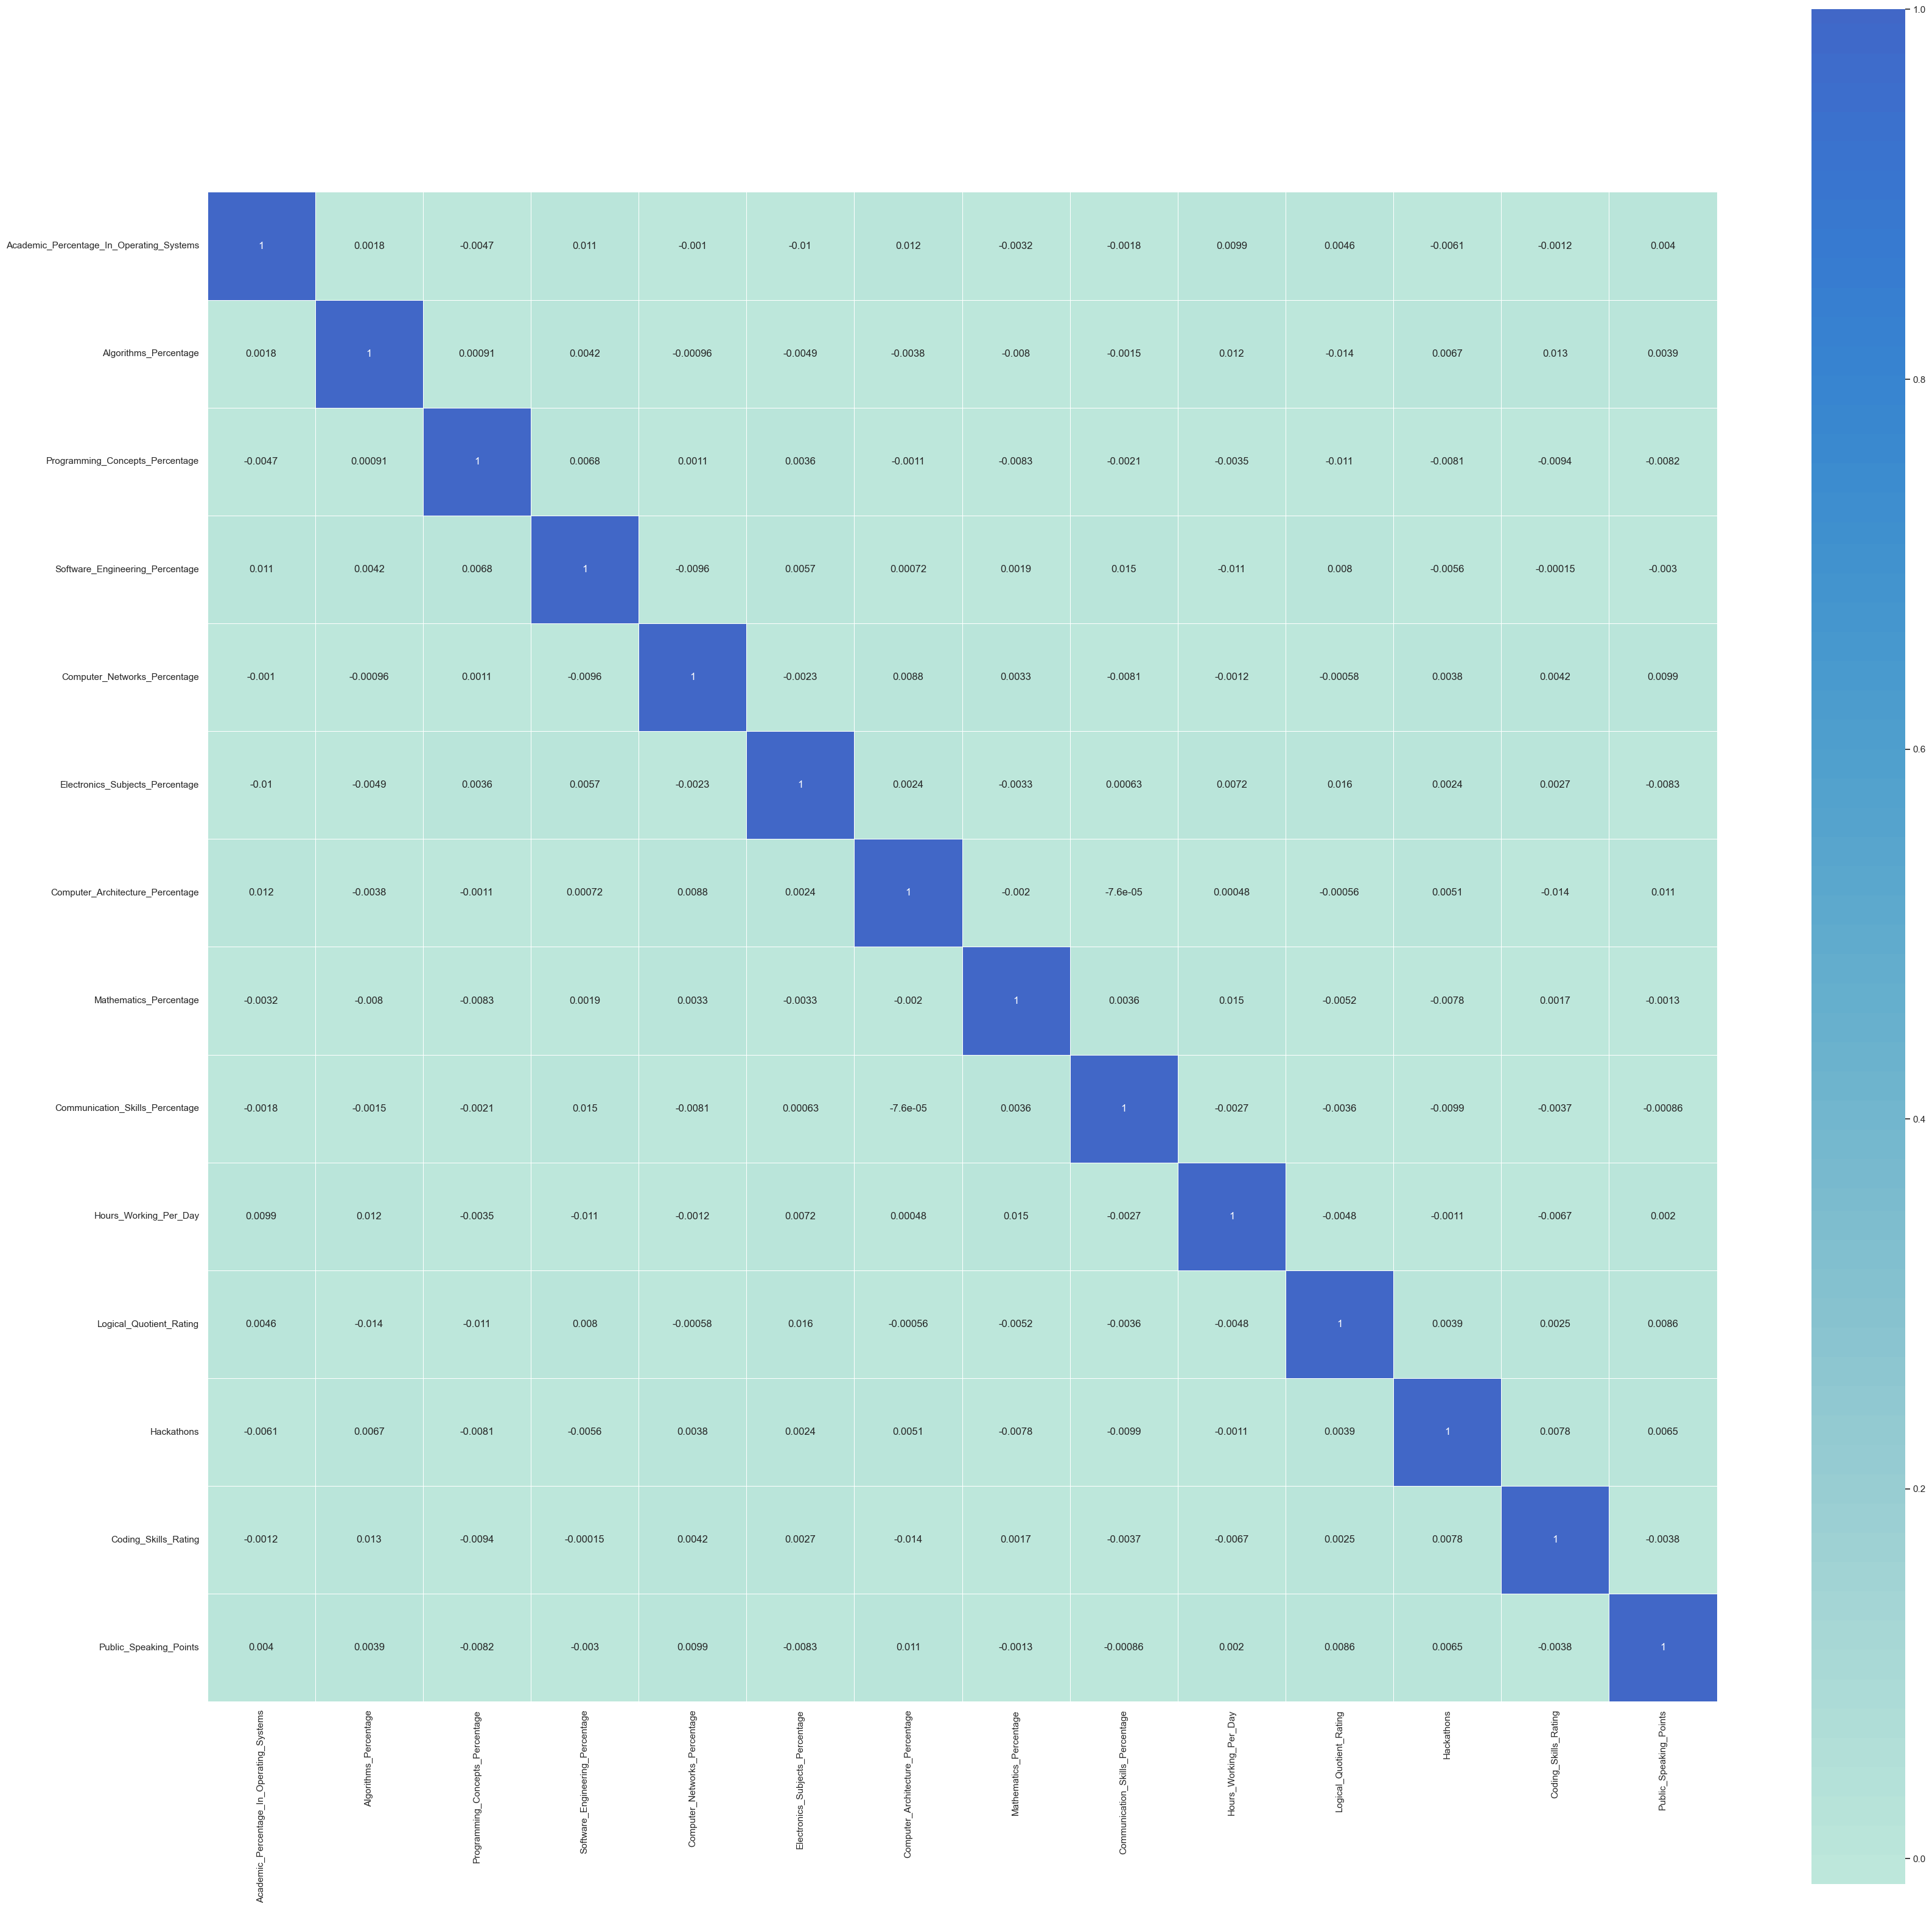

In [158]:
df3 = df.drop(columns = ["Suggested_Job_Role"])
df3 = df3.corr()
f,axes = plt.subplots(1,1,figsize = (40,40))
sns.heatmap(df3,square=True,annot = True,linewidth = .4,center = 2,ax = axes)

In [159]:
pca = PCA()
pca.fit(df3)
PC_components = np.arange(pca.n_components_) + 1

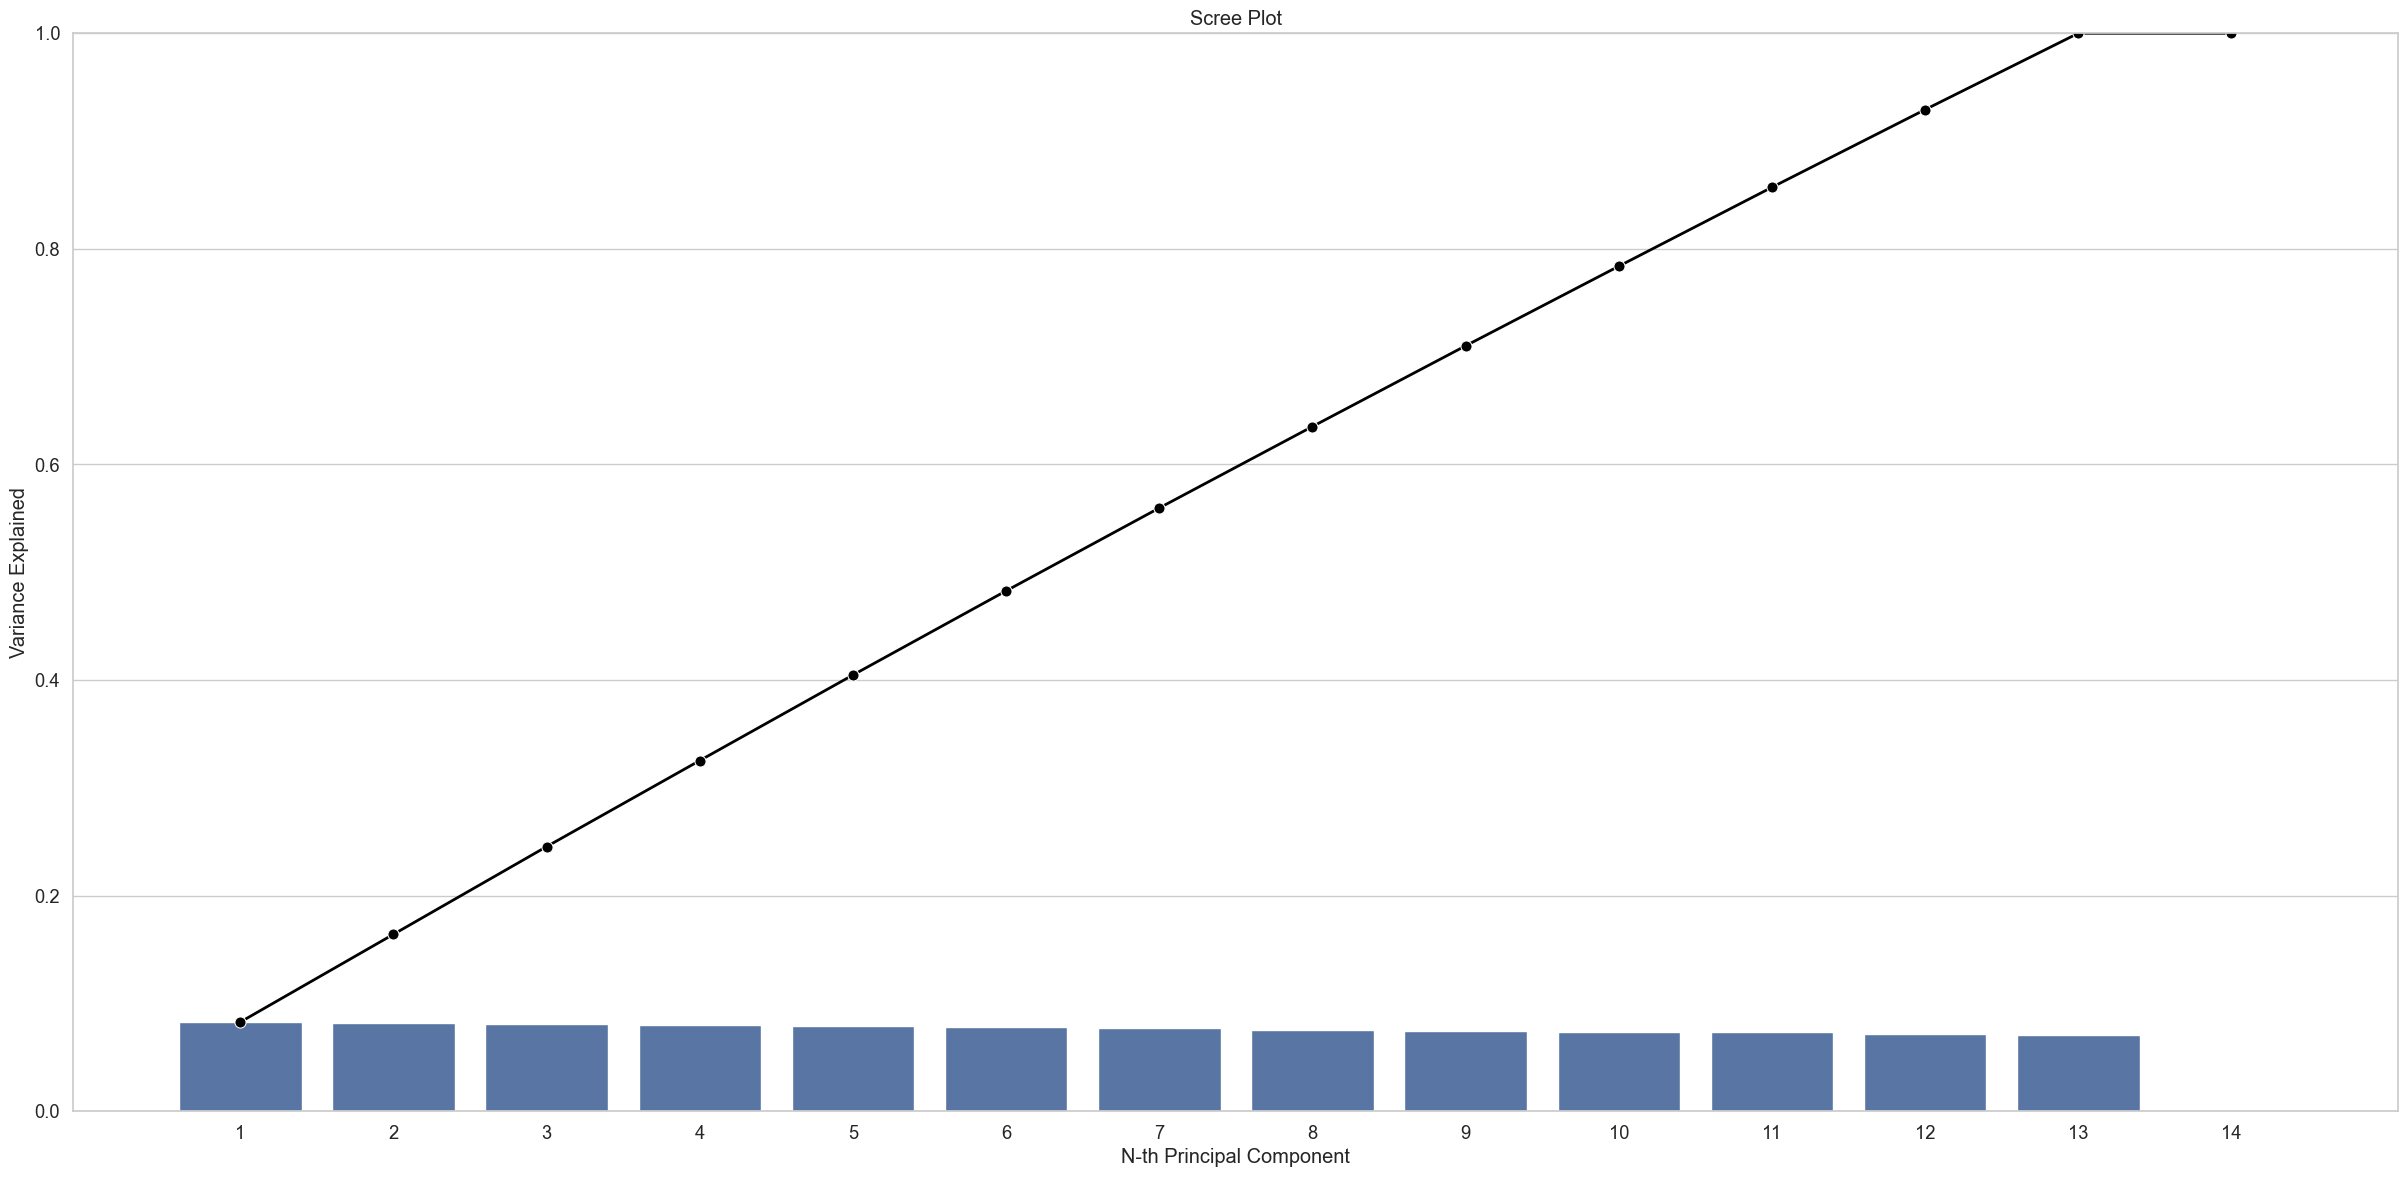

In [160]:
# Scree Plot
scree_plot = sns.set(style='whitegrid', font_scale=1.2)
fig, ax = plt.subplots(figsize=(30, 14))
scree_plot = sns.barplot(x=PC_components, y=pca.explained_variance_ratio_, color='b')
scree_plot = sns.lineplot(x=PC_components-1, y=np.cumsum(pca.explained_variance_ratio_), color='black', linestyle='-', linewidth=2, marker='o', markersize=8)

plt.title('Scree Plot')
plt.xlabel('N-th Principal Component')
plt.ylabel('Variance Explained')
plt.ylim(0, 1)
plt.show()
#As you see after 18 feature relation, there is no change in data explainability.
#Which means we can use 18 feature to explain our data.

As you see, with specific 6 columns,we obtained nothing. So, we decided to find and drop them.

In [161]:
drop_list = high_correlated_cols(df)

In [162]:
drop_list

[]

In [163]:
#df.drop(columns=drop_list, axis = 1, inplace=True)

### Encoding the Features

In [164]:
dummy_cols = ['Interested_Subjects',
              'Interested_Career_Area',
              'Type_Of_Company_Want_To_Settle_In',
              'Worker_Type','Certifications',
              'Workshops']

In [165]:
cat_cols.remove("Suggested_Job_Role")
label_encoder = LabelEncoder()
for cat_col in cat_cols:
    if cat_col not in dummy_cols:
        df[cat_col]= label_encoder.fit_transform(df[cat_col])

In [166]:
df2 = df[dummy_cols]

In [167]:
df2 = pd.get_dummies(df2,prefix="dum")

In [168]:
df = df.join(df2)

In [169]:
df.drop(columns=dummy_cols, inplace=True)

In [170]:
df['Suggested_Job_Role'] = df.pop('Suggested_Job_Role')

In [171]:
df.head()

,Academic_Percentage_In_Operating_Systems,Algorithms_Percentage,Programming_Concepts_Percentage,Software_Engineering_Percentage,Computer_Networks_Percentage,Electronics_Subjects_Percentage,Computer_Architecture_Percentage,Mathematics_Percentage,Communication_Skills_Percentage,Hours_Working_Per_Day,...,dum_shell programming,dum_cloud computing,dum_data science,dum_database security,dum_game development,dum_hacking,dum_system designing,dum_testing,dum_web technologies,Suggested_Job_Role
0,-0.793450,-1.380807,0.096941,0.981950,1.700806,1.670279,0.986229,0.699022,-1.575875,0.390962,...,1,1,0,0,0,0,0,0,0,Database Administrator
1,0.098925,-1.479803,-0.396421,-1.694608,-0.594640,-0.689921,-0.404204,0.699022,1.393469,1.547595,...,0,0,0,1,0,0,0,0,0,Project Manager
2,-0.595145,0.896086,1.379680,0.981950,-1.592660,0.391837,-0.503520,-0.484608,1.690403,1.162051,...,0,0,0,0,0,0,0,0,1,Project Manager
3,-0.099381,0.995082,-1.679160,0.684554,1.201796,-0.394896,-1.496687,1.093566,-0.784050,-0.380128,...,0,0,1,0,0,0,0,0,0,Security Administrator
4,1.487064,-1.479803,1.281008,-1.000686,-0.594640,1.178570,-0.404204,-0.583244,-0.388138,-1.536762,...,0,1,0,0,0,0,0,0,0,Business Intelligence Analyst


Same column names, second ones will be changed.

In [172]:
arr = []
count = 1
for col in df.columns:
    if col in arr:
        print(col)
        col = str(col)+str(count)
        count+=1
        arr.append(col)
    else:
        arr.append(col)

df.columns = arr

dum_cloud computing
dum_cloud computing
dum_hacking
dum_testing


We thought that the interested type of book is unnecessary and decided to drop that as well.

In [173]:
df.drop(columns=['Interested_Type_Of_Books','Salary/Work'], axis=1,inplace=True)

In [174]:
df.corr()

,Academic_Percentage_In_Operating_Systems,Algorithms_Percentage,Programming_Concepts_Percentage,Software_Engineering_Percentage,Computer_Networks_Percentage,Electronics_Subjects_Percentage,Computer_Architecture_Percentage,Mathematics_Percentage,Communication_Skills_Percentage,Hours_Working_Per_Day,...,dum_r programming,dum_shell programming,dum_cloud computing2,dum_data science,dum_database security,dum_game development,dum_hacking3,dum_system designing,dum_testing4,dum_web technologies
Academic_Percentage_In_Operating_Systems,1.000000,0.001781,-0.004693,0.010691,-0.001003,-0.010402,0.011958,-0.003203,-0.001770,0.009925,...,0.001074,-0.002261,-0.010429,0.003940,0.006849,-0.002835,0.005306,-0.003674,-0.007729,0.008172
Algorithms_Percentage,0.001781,1.000000,0.000914,0.004178,-0.000961,-0.004914,-0.003793,-0.007968,-0.001485,0.011567,...,-0.004820,0.005553,0.011455,0.003964,-0.000621,0.001724,-0.000871,-0.006055,-0.008212,-0.001255
Programming_Concepts_Percentage,-0.004693,0.000914,1.000000,0.006810,0.001120,0.003585,-0.001093,-0.008326,-0.002105,-0.003532,...,-0.007271,0.000101,0.013215,-0.000958,0.001812,-0.007896,-0.008234,-0.009732,0.008633,0.003464
Software_Engineering_Percentage,0.010691,0.004178,0.006810,1.000000,-0.009601,0.005680,0.000722,0.001932,0.015085,-0.011287,...,-0.002466,-0.010080,-0.013642,-0.003953,-0.013119,-0.003544,0.007142,0.007985,0.024987,-0.005693
Computer_Networks_Percentage,-0.001003,-0.000961,0.001120,-0.009601,1.000000,-0.002255,0.008840,0.003276,-0.008065,-0.001204,...,0.003491,-0.005981,-0.006553,-0.002294,-0.009264,0.005298,0.003037,0.013801,-0.011394,0.007036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dum_game development,-0.002835,0.001724,-0.007896,-0.003544,0.005298,-0.007735,0.007971,0.006153,0.007336,-0.003866,...,-0.001365,0.008111,-0.139975,-0.145243,-0.144132,1.000000,-0.142687,-0.144099,-0.141731,-0.146383
dum_hacking3,0.005306,-0.000871,-0.008234,0.007142,0.003037,-0.000873,0.005948,-0.007642,0.000019,0.001625,...,0.003682,-0.005507,-0.138414,-0.143624,-0.142525,-0.142687,1.000000,-0.142493,-0.140151,-0.144752
dum_system designing,-0.003674,-0.006055,-0.009732,0.007985,0.013801,0.013328,-0.001464,0.003400,-0.000841,0.008972,...,-0.010540,-0.002052,-0.139784,-0.145046,-0.143936,-0.144099,-0.142493,1.000000,-0.141538,-0.146184
dum_testing4,-0.007729,-0.008212,0.008633,0.024987,-0.011394,0.004714,-0.006940,0.002596,-0.003053,-0.007455,...,0.006248,0.008599,-0.137487,-0.142662,-0.141570,-0.141731,-0.140151,-0.141538,1.000000,-0.143781


<AxesSubplot: xlabel='Suggested_Job_Role', ylabel='count'>

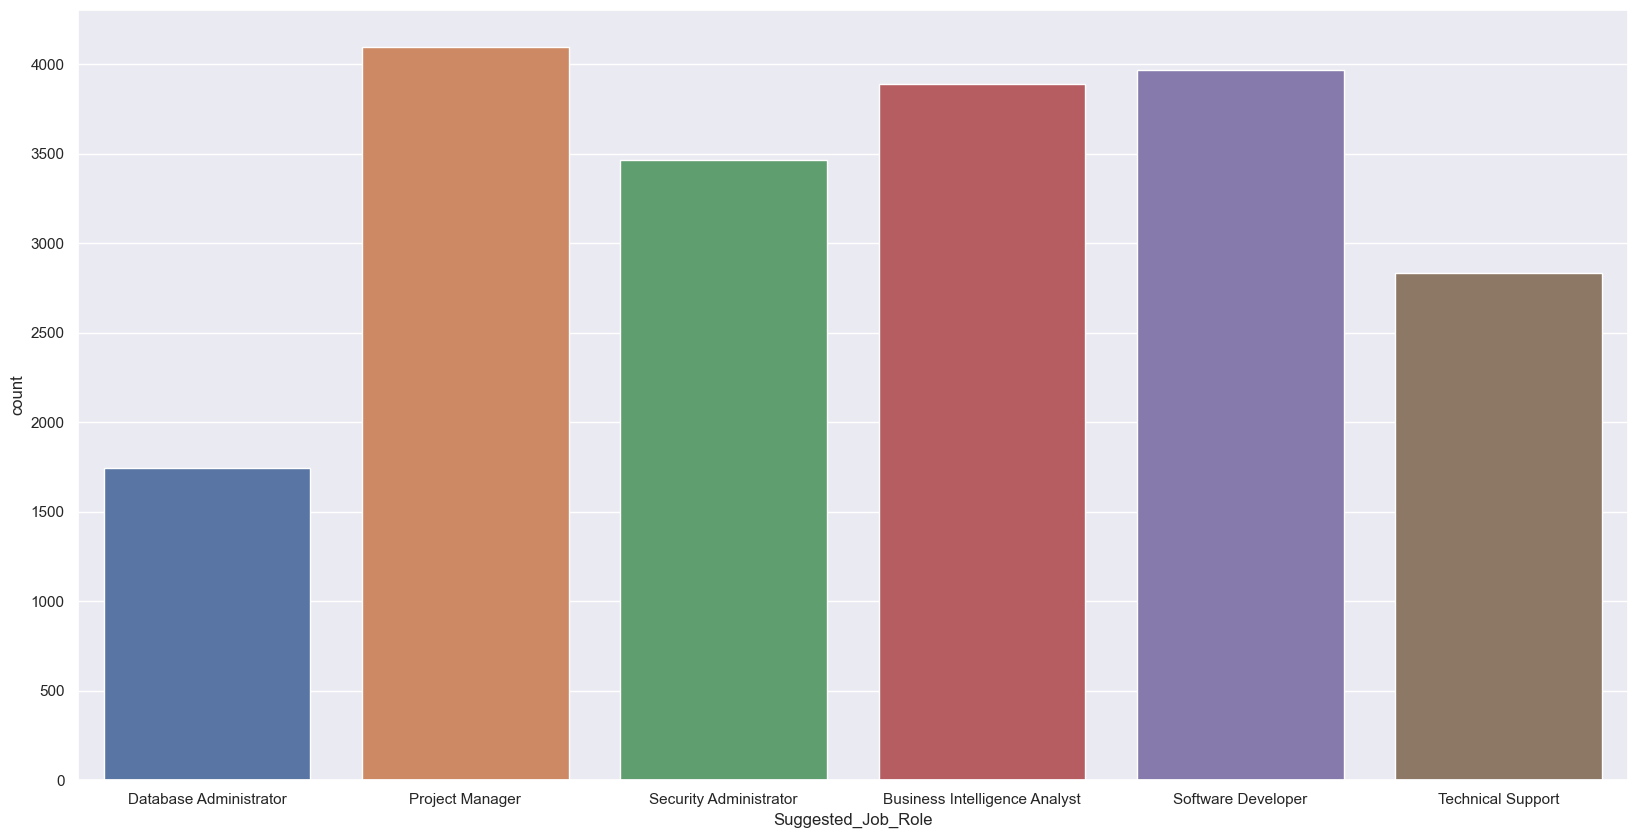

In [175]:
# Checking for data imbalanceness if any
sns.set(rc={'figure.figsize':(20,10)})
sns.countplot(x = df["Suggested_Job_Role"])

Actually there is an imbalance situation between database administrator and other classes. We will examine this problem later.

Creating a decision tree model just for seeing the importance of features

In [176]:
X = df.drop(columns=["Suggested_Job_Role"],axis=1)
y = df["Suggested_Job_Role"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

In [177]:
decision_tree_model = tree.DecisionTreeClassifier(random_state = 0)
decision_tree_model.fit(X_train, y_train)

y_pred = decision_tree_model.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
accuracy = accuracy_score(y_test,y_pred)
print("confusion matrix=\n",cm)
print("  ")
print("accuracy=",accuracy*100)

confusion matrix=
 [[223 123 235 190 234 159]
 [ 98  57 104  92  90  87]
 [245  97 229 217 242 178]
 [202  92 198 182 232 148]
 [248 113 210 187 245 178]
 [183  62 172 157 163 128]]
  
accuracy= 17.733333333333334


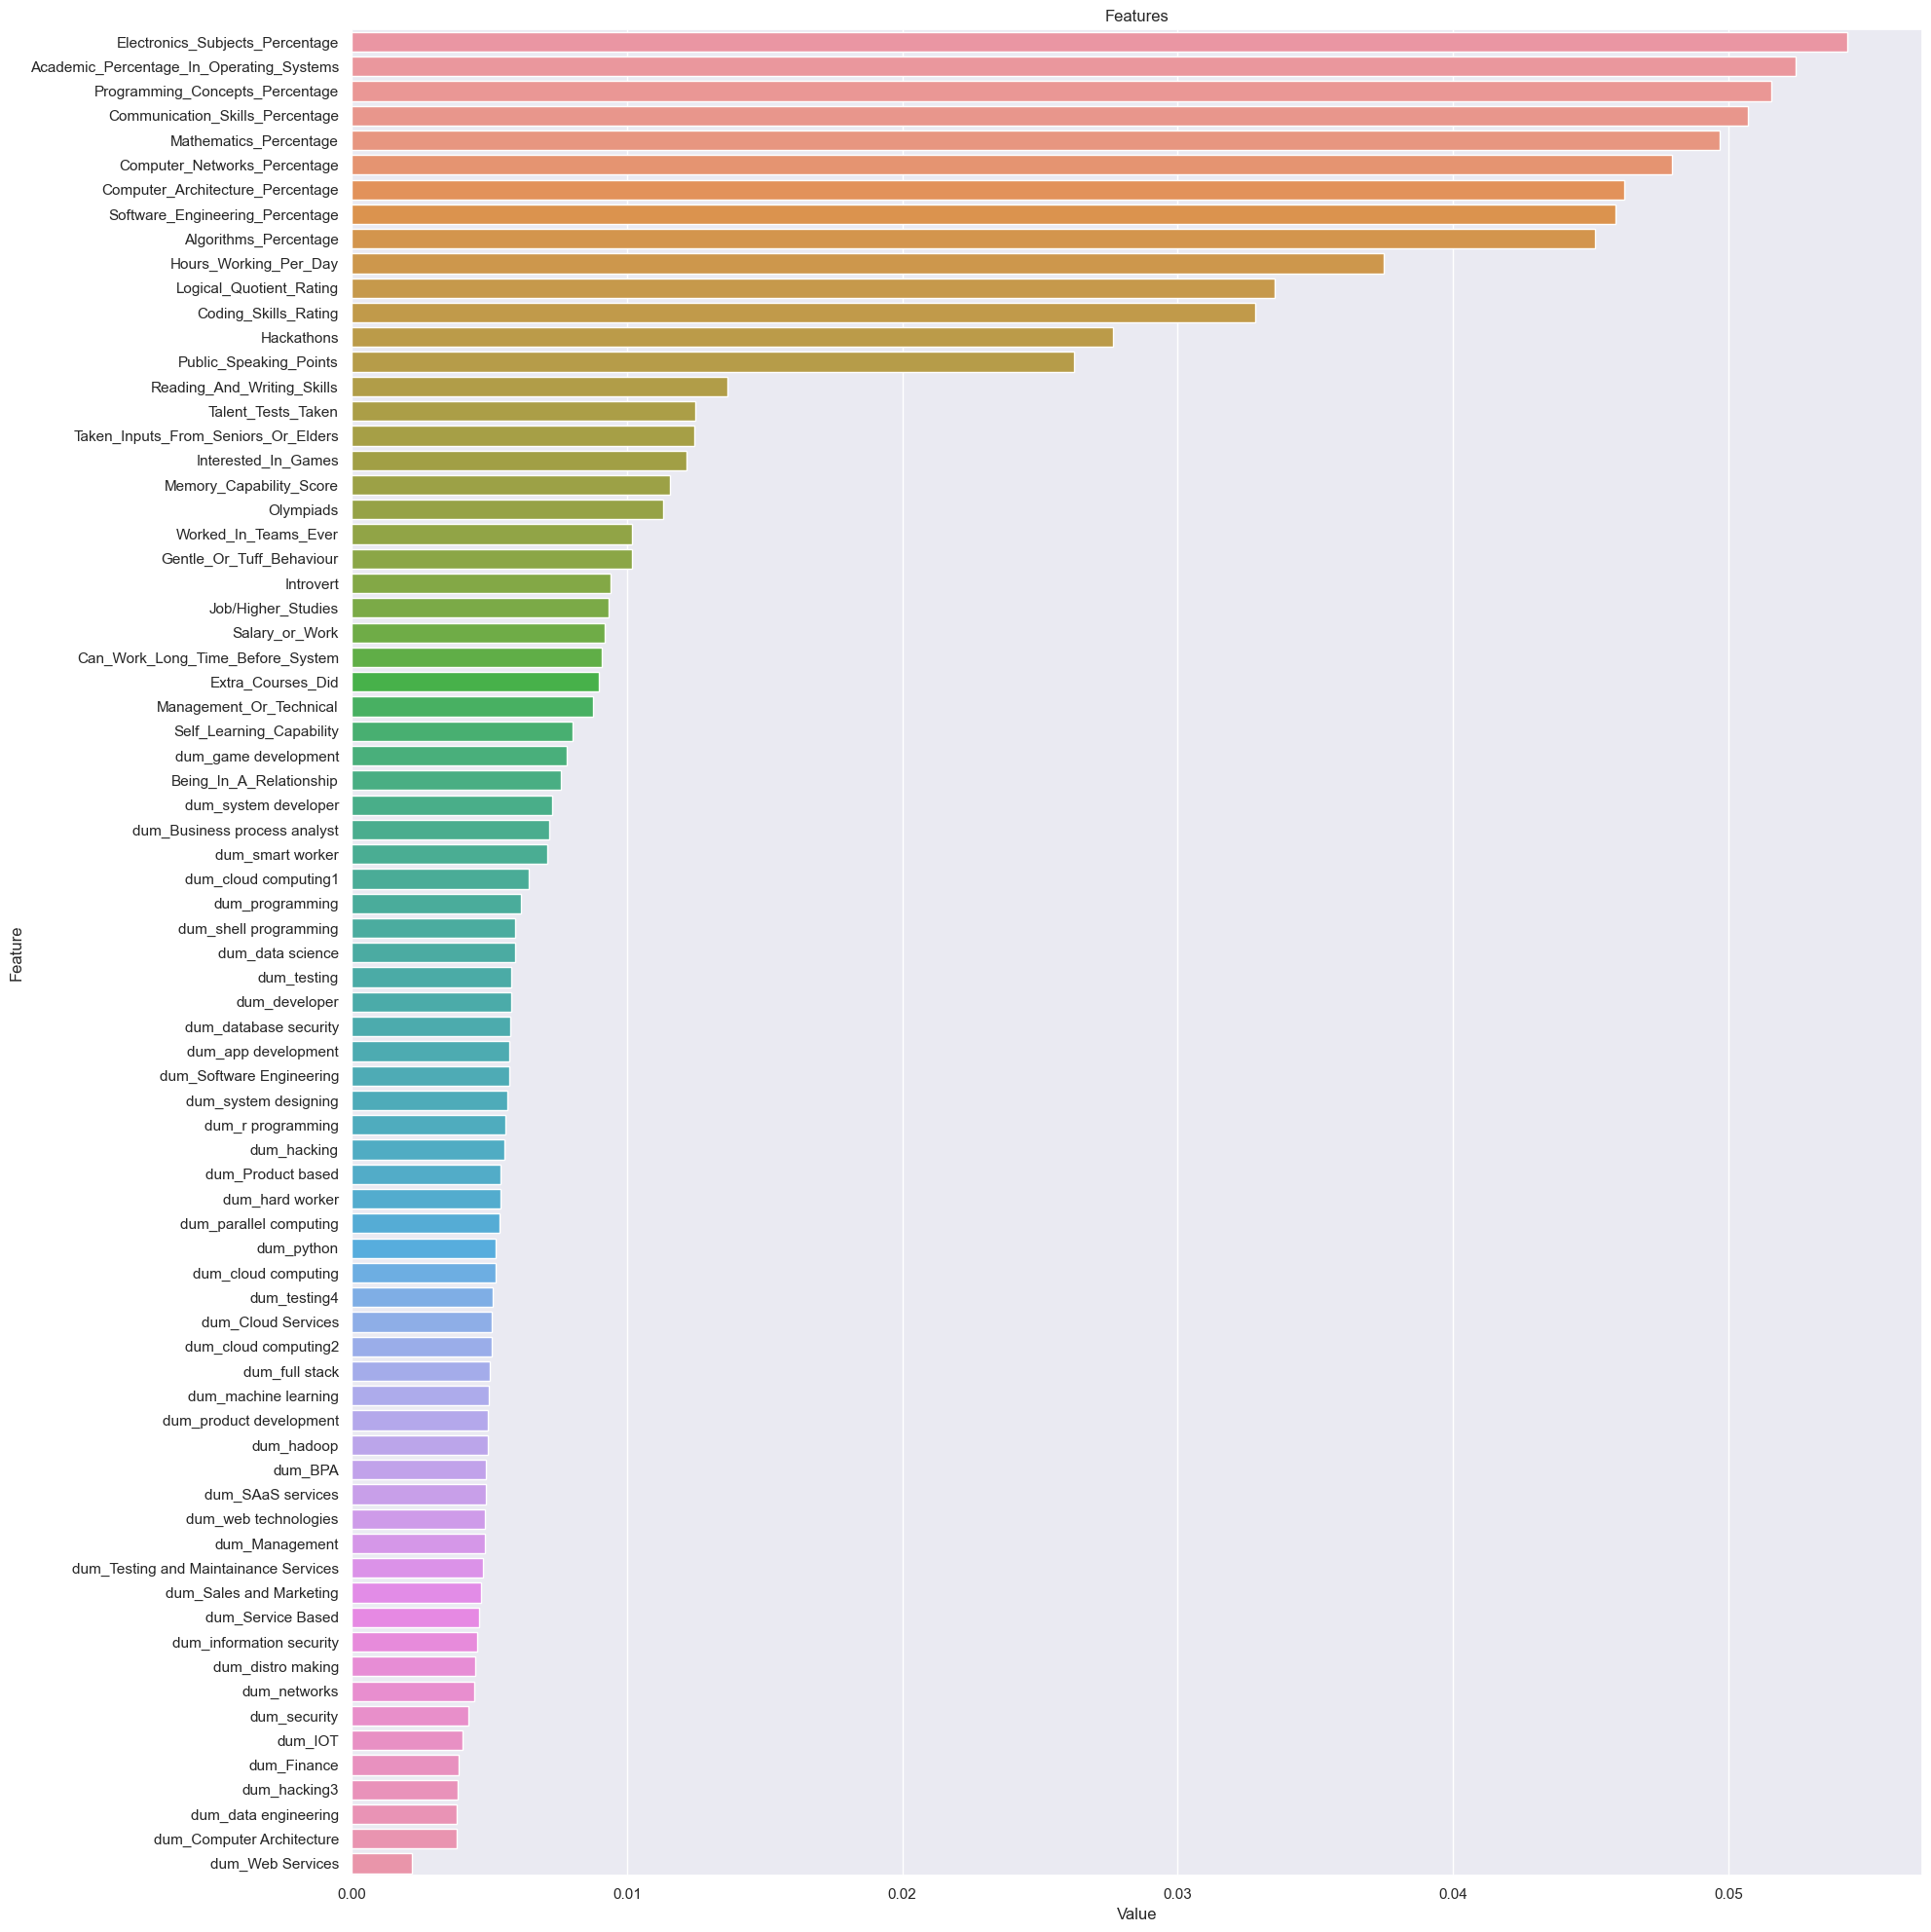

In [178]:
plot_importance(decision_tree_model,X)

#### Feature Engineering

In [179]:
#Introvert no = 0
def categorise_confidence(row,col_avg):
    if row['Public_Speaking_Points'] > col_avg and row['Introvert'] == 0:
        return 'self_confident'
    elif row['Public_Speaking_Points'] > col_avg and row['Introvert'] == 1:
        return 'only_introvert'
    elif row['Public_Speaking_Points'] < col_avg and row['Introvert'] == 0:
        return 'not_self_confident'
    elif row['Public_Speaking_Points'] < col_avg and row['Introvert'] == 1:
        return 'low_speaking_skill'

In [180]:
col_avg = df["Public_Speaking_Points"].mean()
df['Confidence'] = df.apply (lambda row: categorise_confidence(row,col_avg), axis=1)
df2 = pd.get_dummies(df["Confidence"], prefix="dum", drop_first=True)
df = df.join(df2)
df.drop(columns=["Confidence"], axis = 1, inplace=True)

In [181]:
def categorise_security(row):
    if row['dum_information security'] == 1 or  row['dum_database security'] == 1 or  row['dum_security'] == 1:
        return 1
    else:
        return 0

In [182]:
df['Security'] = df.apply (lambda row: categorise_security(row), axis=1)

In [183]:
def categorise_coding(row):
    if row['Coding_Skills_Rating'] < 3:
        return 'low_coding_skill'
    elif 3 <= row['Coding_Skills_Rating'] < 6:
        return 'medium_coding_skill'
    else:
        return 'high_coding'

In [184]:
df['Coding_Skills'] = df.apply (lambda row: categorise_coding(row), axis=1)
df2 = pd.get_dummies(df["Coding_Skills"], prefix="dum", drop_first=True)
df = df.join(df2)
df.drop(columns=["Coding_Skills"], axis = 1, inplace=True)

In [185]:
df["LogicalQuotient_Memory"] = df["Logical_Quotient_Rating"]*df["Memory_Capability_Score"]

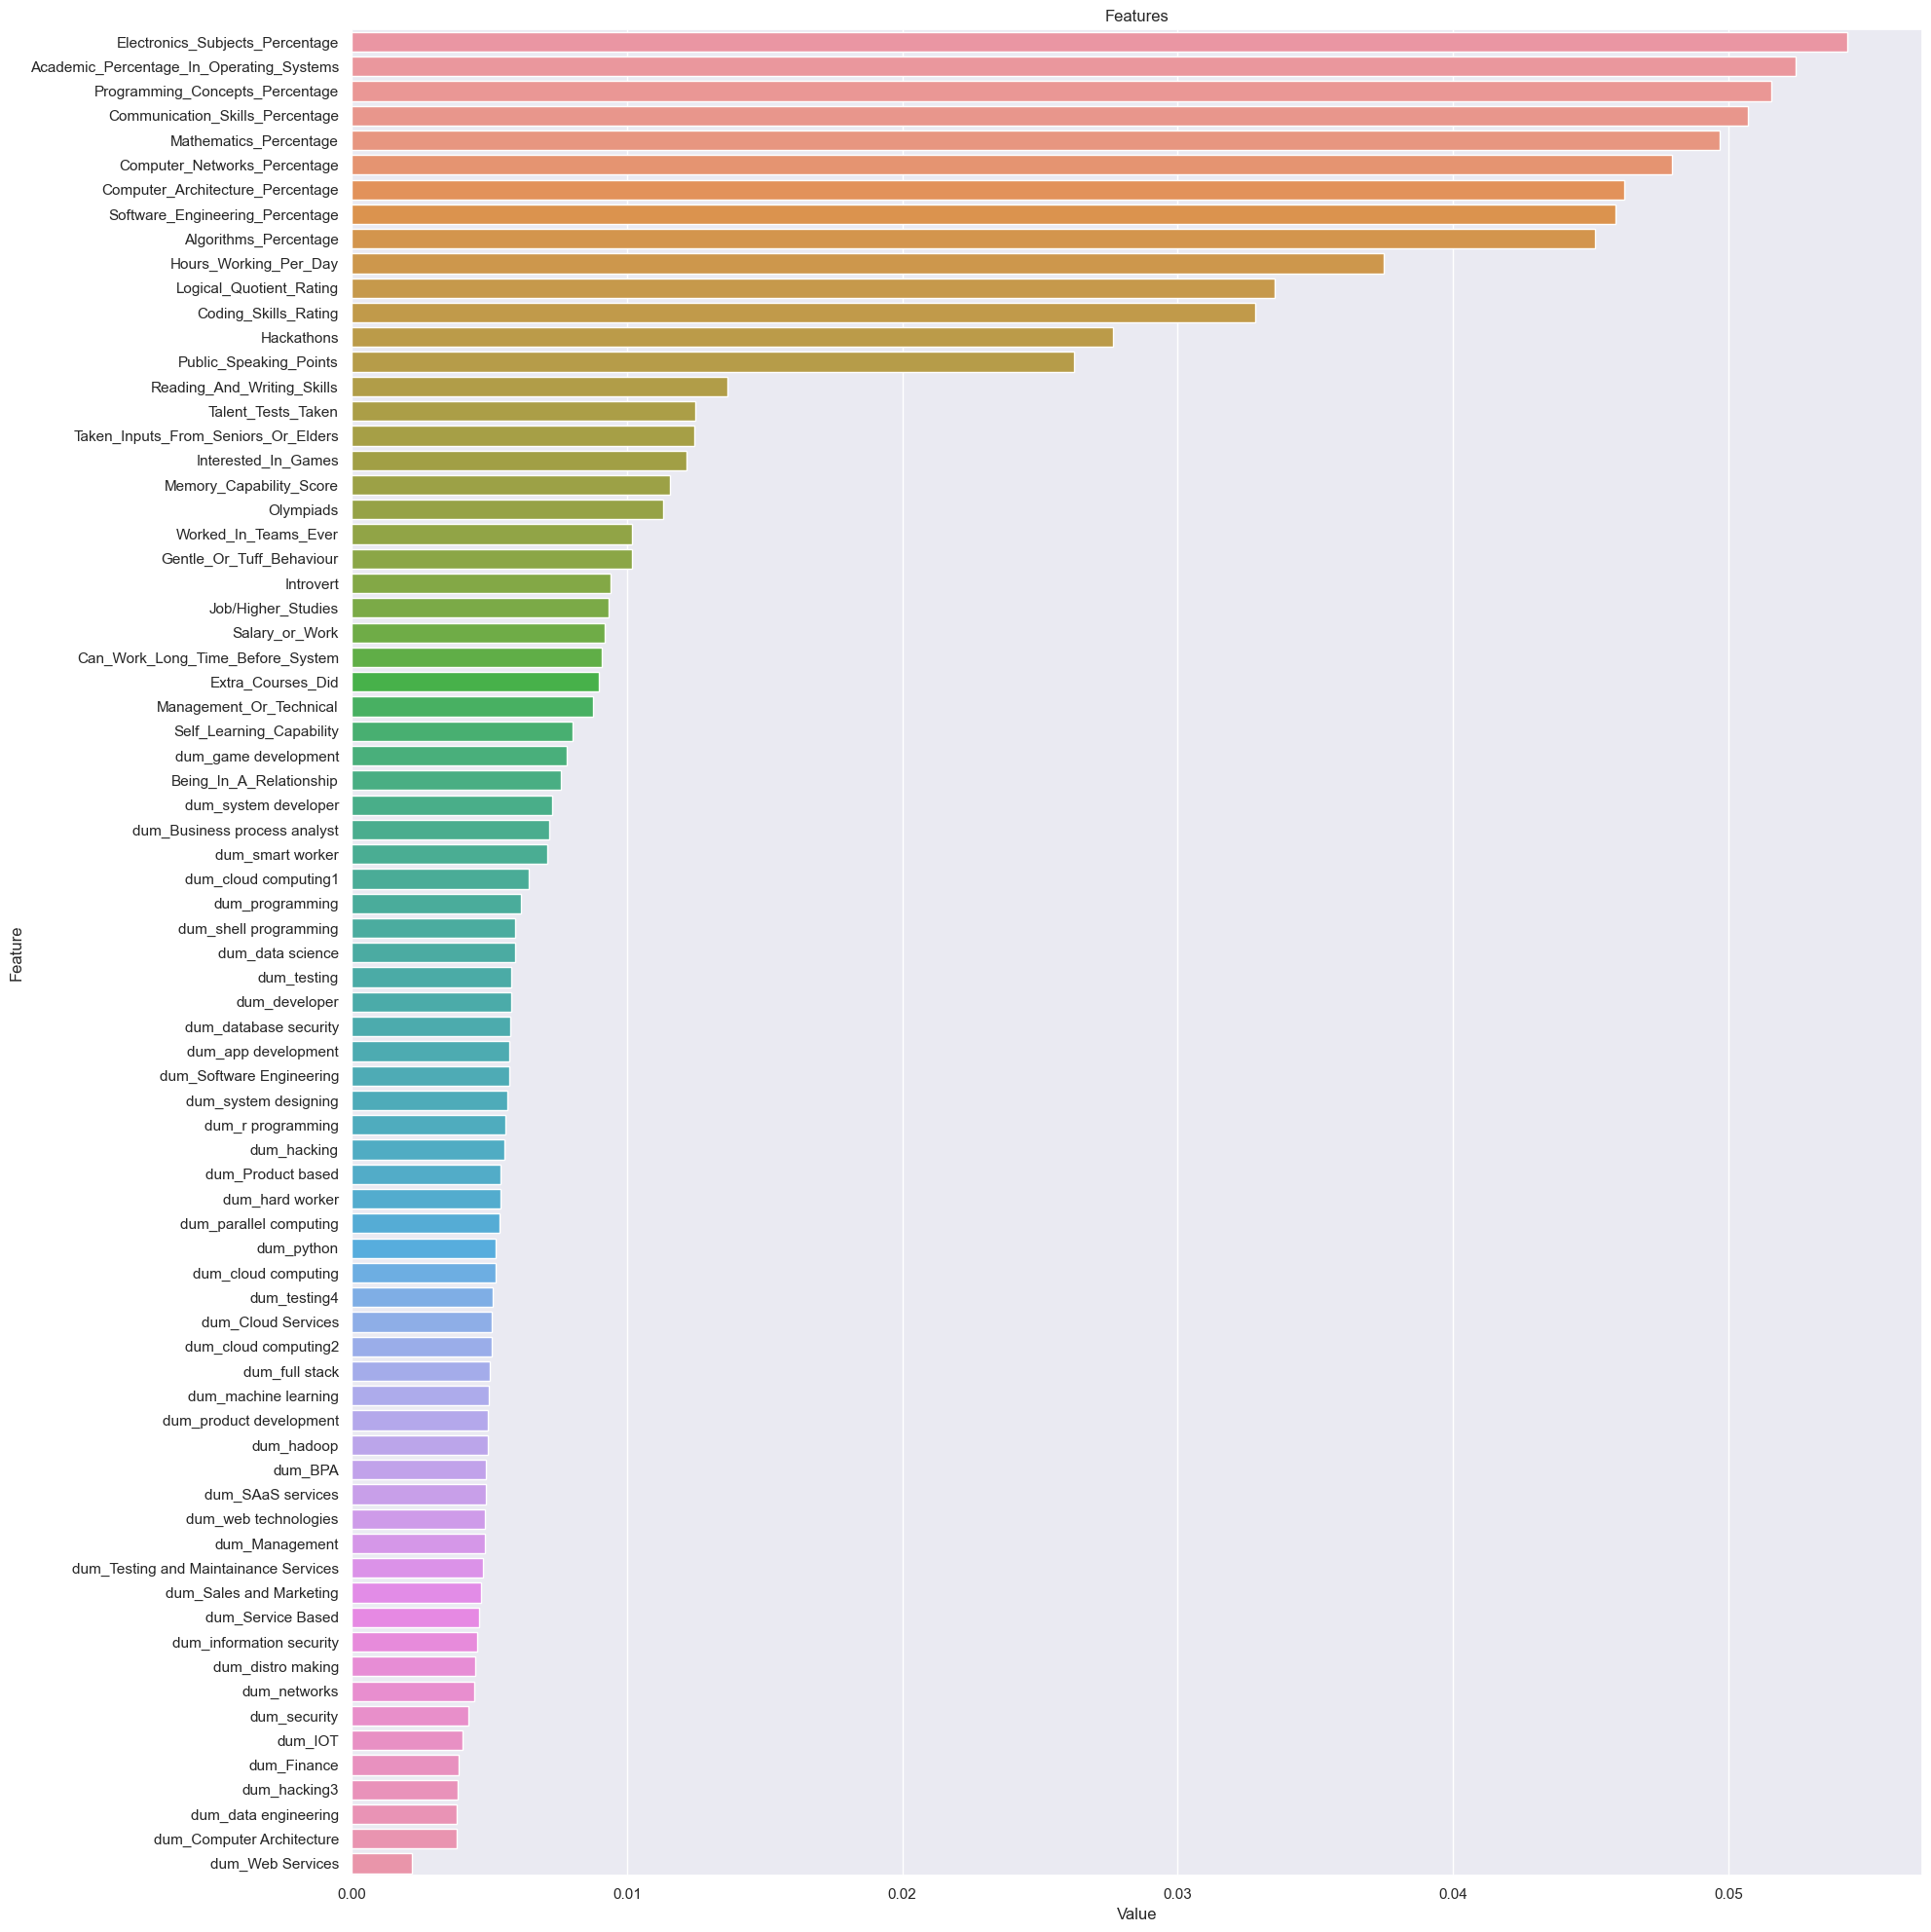

In [186]:
plot_importance(decision_tree_model,X)

In [187]:
df['Suggested_Job_Role'] = df.pop('Suggested_Job_Role')

## Creating Models

In [188]:
#df = shuffle(df)
X = df.drop(columns=["Suggested_Job_Role"], axis=1)
y = df.Suggested_Job_Role

In [189]:
label_encoder = LabelEncoder()
label_encoder.fit(y)
y = label_encoder.transform(y)
pd.DataFrame(y).value_counts()

2    4099
4    3968
0    3889
3    3468
5    2832
1    1744
dtype: int64

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0, test_size=0.3)

## *Decision Tree Model*

In [191]:
decision_tree_model = tree.DecisionTreeClassifier(random_state = 0)
decision_tree_model.fit(X_train, y_train)

decision_tree_predictions = decision_tree_model.predict(X_test)
cm = confusion_matrix(y_test,decision_tree_predictions)
accuracy = accuracy_score(y_test,decision_tree_predictions)
print("confusion matrix=\n",cm)
print("  ")
print("accuracy=",accuracy*100)

confusion matrix=
 [[228 105 253 202 220 156]
 [104  55 117  90  97  65]
 [258 105 218 222 249 156]
 [190  95 228 178 204 159]
 [233 103 235 192 219 199]
 [177  72 173 143 180 120]]
  
accuracy= 16.966666666666665


## *Logistic Regression Model*

In [192]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

lr_predictions = lr_model.predict(X_test)
cm = confusion_matrix(y_test,lr_predictions)
accuracy = accuracy_score(y_test,lr_predictions)
print("confusion matrix=\n",cm)
print("  ")
print("accuracy=",accuracy*100)

confusion matrix=
 [[324   0 467  94 263  16]
 [147   0 189  44 143   5]
 [304   0 488  99 298  19]
 [247   0 417 109 262  19]
 [315   0 449 111 287  19]
 [226   0 355  71 201  12]]
  
accuracy= 20.333333333333332


-- Grid Search CV for choosing best params to Logistic Regression model --

In [193]:
param_grid_lr = {
    'max_iter': [5,10,20, 50, 100, 200, 500, 1000],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'class_weight': ['balanced']
}

In [194]:
# logModel_grid = GridSearchCV(estimator=LogisticRegression(random_state=0), param_grid=param_grid_lr, verbose=1, cv=10, n_jobs=-1)
# logModel_grid.fit(X_train, y_train)
# print(logModel_grid.best_estimator_)

In [195]:
log_model = LogisticRegression(C=100, class_weight='balanced', max_iter=50, random_state=0,solver='liblinear',penalty="l1")
log_model.fit(X_train, y_train)
y_pred = log_model.predict(X_test)
print(y_pred)

[5 5 2 ... 2 2 3]


In [196]:
accuracy = accuracy_score(y_test,y_pred)
accuracy

0.1835

## *Support Vector Machine Model*

In [197]:
svm_model = svm.SVC(kernel="rbf")
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)
svm_cm = confusion_matrix(y_test,svm_predictions)
svm_accuracy = accuracy_score(y_test,svm_predictions)
print("confusion matrics=\n",svm_cm)
print("  ")
print("accuracy=",svm_accuracy*100)

confusion matrics=
 [[313   0 435  95 320   1]
 [148   0 173  42 165   0]
 [322   0 455 110 320   1]
 [252   0 400  99 299   4]
 [282   0 465 114 316   4]
 [240   0 320  72 229   4]]
  
accuracy= 19.783333333333335


## *Random Forest Model*

In [198]:
random_forest_model = RandomForestClassifier(random_state=0)
random_forest_model.fit(X_train, y_train)
random_forest_predictions = random_forest_model.predict(X_test)
rfc_cm = confusion_matrix(y_test,random_forest_predictions)
rfc_accuracy = accuracy_score(y_test,random_forest_predictions)
print("confusion matrics=\n",rfc_cm)
print("  ")
print("accuracy=",rfc_accuracy*100)

confusion matrics=
 [[327   1 418 121 273  24]
 [135   2 180  62 138  11]
 [328   2 408 144 292  34]
 [292   1 346 125 264  26]
 [323   1 404 126 295  32]
 [246   1 304  96 192  26]]
  
accuracy= 19.716666666666665


In [199]:
pd.DataFrame(random_forest_predictions).value_counts()

2    2060
0    1651
4    1454
3     674
5     153
1       8
dtype: int64

In [200]:
random_forest_model.predict_proba(X_test)

array([[0.15, 0.05, 0.33, 0.18, 0.17, 0.12],
       [0.21, 0.06, 0.25, 0.16, 0.19, 0.13],
       [0.18, 0.04, 0.21, 0.22, 0.21, 0.14],
       ...,
       [0.23, 0.08, 0.16, 0.22, 0.17, 0.14],
       [0.15, 0.06, 0.2 , 0.23, 0.18, 0.18],
       [0.16, 0.08, 0.25, 0.2 , 0.22, 0.09]])

## *XGBoost Model*

In [201]:
eval_set = [(X_train, y_train), (X_test, y_test)]

xgboost_model=XGBClassifier(eval_metric=['merror','mlogloss'],learning_rate=0.02,objective='multi:softmax')
"""objective='multi:softmax',
                        num_class=6,
                        missing=0,
                        gamma=1, # default gamma value
                        learning_rate=0.002,
                        max_depth=3,
                        reg_lambda=1, # default L2 value
                        subsample=1, # default subsample value
                        colsample_bytree=1, # default colsample_bytree value
                        early_stopping_rounds=10,
                        eval_metric=['merror','mlogloss'],
                        seed=0"""
xgboost_model.fit(X_train,y_train, eval_set=eval_set,verbose = 0)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=['merror', 'mlogloss'], feature_types=None, gamma=0,
              gpu_id=-1, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.02, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, objective='multi:softmax', predictor='auto', ...)

In [202]:
arr = []
for col in df.columns:
    if col in arr:
        print(col)
        df.rename(columns = {col:col+'2'}, inplace = True)
        arr.append(col+'2')
    else:
        arr.append(col)

In [203]:
xgboost_predictions = xgboost_model.predict(X_test)

accuracy = accuracy_score(y_test, xgboost_predictions)
print(accuracy)

print("Accuracy: %.2f%%" % (accuracy * 100.0))

0.19166666666666668
Accuracy: 19.17%


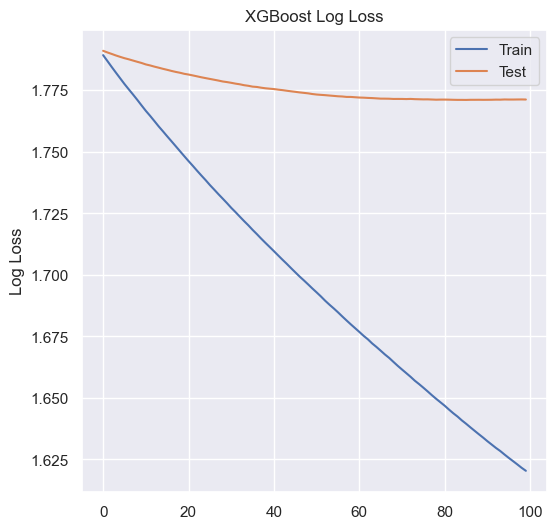

In [204]:
results = xgboost_model.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = pyplot.subplots(figsize=(6, 6))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()

pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()


## *AdaBoost Model*


    Parameters
    -----------
    base_estimator: object
        The base model from which the boosted ensemble is built.
    n_estimators: integer, optional(default=50)
        The maximum number of estimators
    learning_rate: float, optional(default=1)
    algorithm: {'SAMME','SAMME.R'}, optional(default='SAMME.R')
        SAMME.R uses predicted probabilities to update wights, while SAMME uses class error rate
    random_state: int or None, optional(default=None)
    Attributes
    -------------
    estimators_: list of base estimators
    estimator_weights_: array of floats
        Weights for each base_estimator
    estimator_errors_: array of floats
        Classification error for each estimator in the boosted ensemble.
    Reference:
    1. [multi-adaboost](https://web.stanford.edu/~hastie/Papers/samme.pdf)
    2. [scikit-learn:weight_boosting](https://github.com/scikit-learn/
    scikit-learn/blob/51a765a/sklearn/ensemble/weight_boosting.py#L289)


In [205]:
adaboost_model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10),n_estimators=100,learning_rate= 0.02, random_state=0,algorithm="SAMME")
adaboost_model.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=10),
                   learning_rate=0.02, n_estimators=100, random_state=0)

In [206]:
adaboost_predictions = adaboost_model.predict(X_test)
print(classification_report(y_test,adaboost_predictions))

              precision    recall  f1-score   support

           0       0.21      0.26      0.23      1164
           1       0.00      0.00      0.00       528
           2       0.19      0.38      0.26      1208
           3       0.20      0.10      0.13      1054
           4       0.19      0.26      0.22      1181
           5       0.19      0.02      0.03       865

    accuracy                           0.20      6000
   macro avg       0.16      0.17      0.15      6000
weighted avg       0.18      0.20      0.17      6000



## *Gaussian Naive Bayes Model*

In [207]:
gaussian_nb_model = GaussianNB().fit(X_train, y_train)

# accuracy on X_test
accuracy = gaussian_nb_model.score(X_test, y_test)
accuracy

0.1895

## *Gradient Boosting Model*

In [208]:
lr_list = [0.005,0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_model = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=4, random_state=0)
    gb_model.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_model.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_model.score(X_test, y_test)))

Learning rate:  0.005
Accuracy score (training): 0.206
Accuracy score (validation): 0.201
Learning rate:  0.05
Accuracy score (training): 0.248
Accuracy score (validation): 0.195
Learning rate:  0.075
Accuracy score (training): 0.265
Accuracy score (validation): 0.197
Learning rate:  0.1
Accuracy score (training): 0.272
Accuracy score (validation): 0.198
Learning rate:  0.25
Accuracy score (training): 0.297
Accuracy score (validation): 0.197
Learning rate:  0.5
Accuracy score (training): 0.311
Accuracy score (validation): 0.197
Learning rate:  0.75
Accuracy score (training): 0.317
Accuracy score (validation): 0.185
Learning rate:  1
Accuracy score (training): 0.317
Accuracy score (validation): 0.187


In [209]:
gradient_boosting_model = GradientBoostingClassifier(n_estimators=20, learning_rate=0.005, max_features=2, max_depth=2, random_state=0)
gradient_boosting_model.fit(X_train, y_train)
gradient_boosting_predictions = gradient_boosting_model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, gradient_boosting_predictions))

print("Classification Report")
print(classification_report(y_test, gradient_boosting_predictions))

accuracy = gradient_boosting_model.score(X_test, y_test)
print(accuracy*100)

Confusion Matrix:
[[   0    0 1164    0    0    0]
 [   0    0  528    0    0    0]
 [   0    0 1208    0    0    0]
 [   0    0 1054    0    0    0]
 [   0    0 1181    0    0    0]
 [   0    0  865    0    0    0]]
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1164
           1       0.00      0.00      0.00       528
           2       0.20      1.00      0.34      1208
           3       0.00      0.00      0.00      1054
           4       0.00      0.00      0.00      1181
           5       0.00      0.00      0.00       865

    accuracy                           0.20      6000
   macro avg       0.03      0.17      0.06      6000
weighted avg       0.04      0.20      0.07      6000

20.133333333333333


## *K-Neighbors Classifier Model*

In [210]:
from sklearn.neighbors import KNeighborsClassifier
for i in range(1,15,2):
    knn_classifier = KNeighborsClassifier(n_neighbors = i,weights ="distance")
    knn_classifier.fit(X_train, y_train)
    knn_classifier_predictions = knn_classifier.predict(X_test)
    accuracy = accuracy_score(y_test,knn_classifier_predictions)
    print("K: ",i,"Accuracy: ",accuracy)

K:  1 Accuracy:  0.17283333333333334
K:  3 Accuracy:  0.17466666666666666
K:  5 Accuracy:  0.17616666666666667
K:  7 Accuracy:  0.18416666666666667
K:  9 Accuracy:  0.18516666666666667
K:  11 Accuracy:  0.1845
K:  13 Accuracy:  0.18283333333333332


## *Adaboost Model with Voting Classifier*

In [211]:
votingClf = VotingClassifier([('clf1', SVC(probability=True)), ('clf2', DecisionTreeClassifier())], voting='soft')
adaBoostClassifier = AdaBoostClassifier(base_estimator=votingClf)
adaBoostClassifier.fit(X_train, y_train)
y_pred = adaBoostClassifier.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.1705


# Neural Network

In [212]:
df = shuffle(df)

X = np.asarray(X).astype('float32')
Y = np.array(y)


In [213]:
Y = to_categorical(Y)
Y = np.asarray(Y).astype('float32')

In [214]:
train_x, test_x, train_y, test_y = train_test_split(X,y, stratify=y,test_size = 0.3, random_state = 0)
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((14000, 80), (14000,), (6000, 80), (6000,))

In [215]:
train_y = to_categorical(train_y)
train_y = np.asarray(train_y).astype('float32')

test_y = to_categorical(test_y)
test_y = np.asarray(test_y).astype('float32')

In [217]:
from keras.applications.densenet import layers
from keras.optimizers import Adam
from sklearn.utils import class_weight

df = shuffle(df)
model = Sequential()
model.add(Dense(20, input_dim=80))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))
model.add(Dense(60))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))
model.add(Dense(60))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))
model.add(Dense(6))
model.add(layers.Activation('softmax'))

adam = Adam(lr=0.0001, epsilon=1e-8, decay=1e-4, amsgrad=False)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
history = model.fit(train_x, train_y, epochs = 5, batch_size = 64, validation_data=(test_x, test_y))
scores = model.evaluate(test_x, test_y)

for i, m in enumerate(model.metrics_names):
    print(m,scores[i])

Epoch 1/5
219/219 [==============================] - 2s 7ms/step - loss: 1.7998 - accuracy: 0.1882 - val_loss: 1.7731 - val_accuracy: 0.1922
Epoch 2/5
219/219 [==============================] - 1s 6ms/step - loss: 1.7797 - accuracy: 0.1967 - val_loss: 1.7667 - val_accuracy: 0.2013
Epoch 3/5
219/219 [==============================] - 1s 6ms/step - loss: 1.7734 - accuracy: 0.1959 - val_loss: 1.7639 - val_accuracy: 0.2027
Epoch 4/5
219/219 [==============================] - 1s 6ms/step - loss: 1.7690 - accuracy: 0.1951 - val_loss: 1.7622 - val_accuracy: 0.1983
Epoch 5/5
188/188 [==============================] - 1s 3ms/step - loss: 1.7617 - accuracy: 0.1987
loss 1.7616513967514038
accuracy 0.19866666197776794


In [218]:
y_pred = model.predict(test_x)

188/188 [==============================] - 0s 2ms/step


In [219]:
y_pred

array([[0.20410696, 0.10577458, 0.19134194, 0.15702495, 0.2024607 ,
        0.1392909 ],
       [0.18314373, 0.10754586, 0.18618172, 0.17500553, 0.19190149,
        0.15622166],
       [0.20610903, 0.10605826, 0.19363116, 0.1738951 , 0.17803663,
        0.14226979],
       ...,
       [0.18127616, 0.10209239, 0.1941525 , 0.1702554 , 0.20342971,
        0.14879386],
       [0.25516427, 0.09243389, 0.19490491, 0.16460343, 0.17427722,
        0.11861628],
       [0.19940832, 0.10894841, 0.17976639, 0.1779847 , 0.18499257,
        0.14889966]], dtype=float32)

In [220]:
test_size = 6000
pred_ = np.argmax(y_pred,axis=1)

pred_ = label_encoder.inverse_transform(pred_)

# true_y = np.argmax(y_test,axis=1)
# true_y = label_encoder.inverse_transform(true_y)
true_y = label_encoder.inverse_transform(np.argmax(to_categorical(y_test[:test_size]), axis = 1))

count = 0
counter = 0
for i,j in zip(pred_, true_y):
    #print("Predicted: {}, True: {}".format(i, j))
    if j == "Project Manager":
        counter +=1
    if i==j:
        print(j)
        count +=1
print(count)
print(counter)

Project Manager
Business Intelligence Analyst
Business Intelligence Analyst
Project Manager
Business Intelligence Analyst
Software Developer
Business Intelligence Analyst
Business Intelligence Analyst
Software Developer
Business Intelligence Analyst
Business Intelligence Analyst
Business Intelligence Analyst
Business Intelligence Analyst
Project Manager
Business Intelligence Analyst
Business Intelligence Analyst
Business Intelligence Analyst
Business Intelligence Analyst
Business Intelligence Analyst
Business Intelligence Analyst
Software Developer
Business Intelligence Analyst
Software Developer
Business Intelligence Analyst
Software Developer
Business Intelligence Analyst
Project Manager
Project Manager
Business Intelligence Analyst
Software Developer
Business Intelligence Analyst
Software Developer
Project Manager
Software Developer
Project Manager
Business Intelligence Analyst
Software Developer
Business Intelligence Analyst
Software Developer
Business Intelligence Analyst
Business

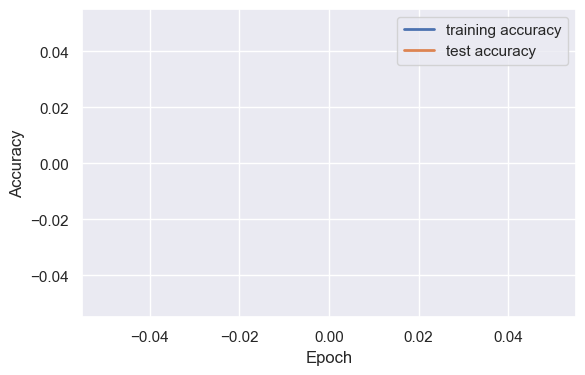

In [221]:
logs = pd.DataFrame(history.history)
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(logs.loc[5:,"accuracy"], lw=2, label='training accuracy')
plt.plot(logs.loc[5:,"val_accuracy"], lw=2, label='test accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

Although we tried many times with different structures, we encountered an overfit situation. That's why we started trying different solutions.

### Transfer Learning

We tried but we cannot find an appropriate model for our dataset

In [222]:
df = shuffle(df)
X = df.drop(['Suggested_Job_Role'], axis=1)
X = np.asarray(X).astype('float32')
Y = np.array(df['Suggested_Job_Role'])

l_encode = LabelEncoder()
l_encode.fit(Y)
Y = l_encode.transform(Y)

In [223]:
classes = {0:"Project Manager",
           1:"Security Administrator",
           2:"Software Developer",
           3:"Business Intelligence Analyst",
           4:"Technical Support",
           5:"Database Administrator"}

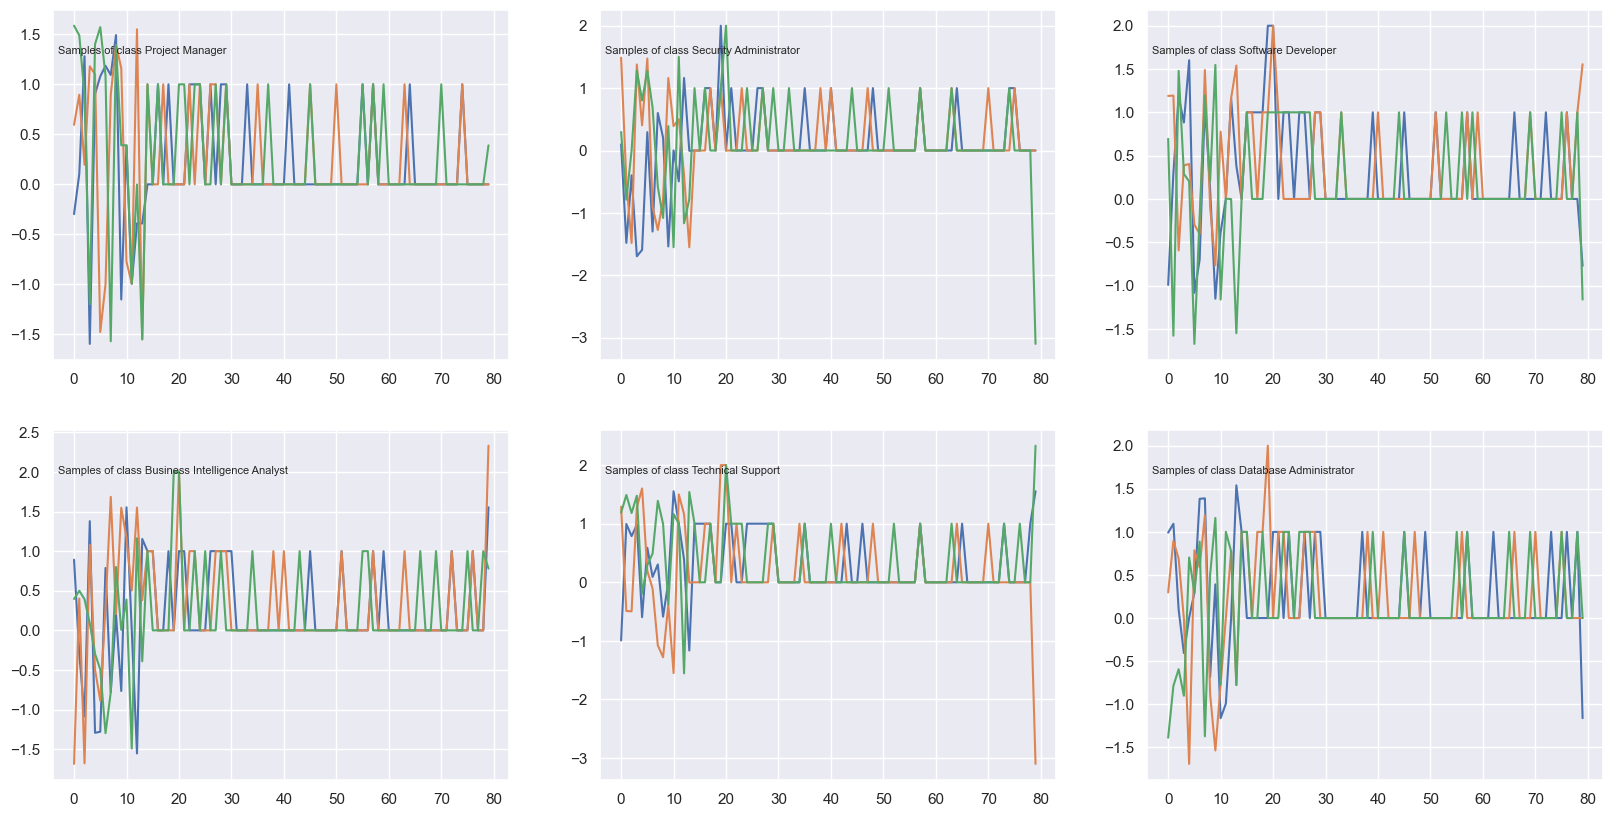

In [224]:
for i in range(0,6):
    plt.subplot(2,3,i + 1)
    all_samples_indexes = np.where(Y == i)[0]
    rand_samples_indexes = np.random.randint(0, len(all_samples_indexes), 3)
    rand_samples = X[rand_samples_indexes]
    plt.plot(rand_samples.transpose())
    plt.title("Samples of class " + classes[i], loc='left', fontdict={'fontsize':8}, x=0.01, y=0.85)

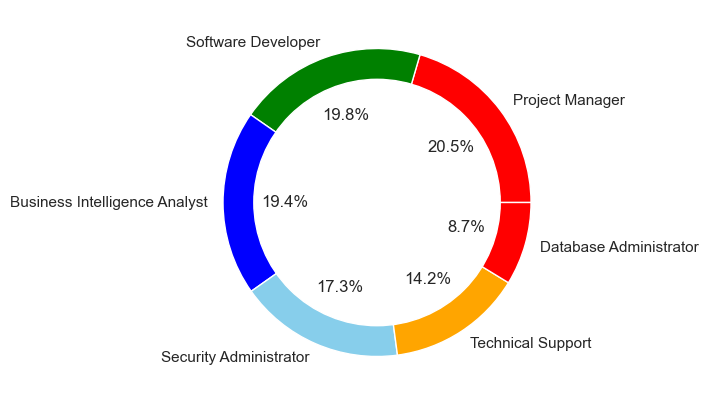

In [225]:
repartition = [4099,3968,3889,3468,2832,1744]

plt.figure(figsize=(5, 5))
circle = plt.Circle((0, 0), 0.8, color='white')
plt.pie(repartition, labels=['Project Manager', 'Software Developer', 'Business Intelligence Analyst', 'Security Administrator', 'Technical Support','Database Administrator'], colors=['red', 'green', 'blue', 'skyblue', 'orange'],
        autopct='%1.1f%%')
p = plt.gcf()
p.gca().add_artist(circle)
plt.show()

In [226]:
########### OVER SAMPLING AND UNDER SAMPLING APPLIED ###############

In [227]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0, test_size=0.3)

In [228]:
from imblearn.over_sampling import SMOTE
from collections import Counter

strategy = {0:3889, 1:3889, 2:4099, 3:3889, 4:3968, 5:3889}
oversample = SMOTE()

X_train, y_train = oversample.fit_resample(X_train, y_train)

In [229]:
gradient_boosting_model = GradientBoostingClassifier(n_estimators=20, learning_rate=0.1, max_features=2, max_depth=2, random_state=0)
gradient_boosting_model.fit(X_train, y_train)
gradient_boosting_predictions = gradient_boosting_model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, gradient_boosting_predictions))

print("Classification Report")
print(classification_report(y_test, gradient_boosting_predictions))

accuracy = gradient_boosting_model.score(X_test, y_test)
print(accuracy*100)

Confusion Matrix:
[[213 176 278 132 256 109]
 [ 86  65 141  61 120  55]
 [209 176 321 116 247 139]
 [183 154 273 112 212 120]
 [225 171 319 117 219 130]
 [160 127 204 108 177  89]]
Classification Report
              precision    recall  f1-score   support

           0       0.20      0.18      0.19      1164
           1       0.07      0.12      0.09       528
           2       0.21      0.27      0.23      1208
           3       0.17      0.11      0.13      1054
           4       0.18      0.19      0.18      1181
           5       0.14      0.10      0.12       865

    accuracy                           0.17      6000
   macro avg       0.16      0.16      0.16      6000
weighted avg       0.17      0.17      0.17      6000

16.983333333333334


In [230]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0, test_size=0.3)

In [231]:
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy='not majority')
X_train, y_train = undersample.fit_resample(X_train, y_train)

In [232]:
gradient_boosting_model = GradientBoostingClassifier(n_estimators=20, learning_rate=0.1, max_features=2, max_depth=2, random_state=0)
gradient_boosting_model.fit(X_train, y_train)
gradient_boosting_predictions = gradient_boosting_model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, gradient_boosting_predictions))

print("Classification Report")
print(classification_report(y_test, gradient_boosting_predictions))

accuracy = gradient_boosting_model.score(X_test, y_test)
print(accuracy*100)

Confusion Matrix:
[[   0    0 1164    0    0    0]
 [   0    0  528    0    0    0]
 [   0    0 1208    0    0    0]
 [   0    0 1054    0    0    0]
 [   0    0 1181    0    0    0]
 [   0    0  865    0    0    0]]
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1164
           1       0.00      0.00      0.00       528
           2       0.20      1.00      0.34      1208
           3       0.00      0.00      0.00      1054
           4       0.00      0.00      0.00      1181
           5       0.00      0.00      0.00       865

    accuracy                           0.20      6000
   macro avg       0.03      0.17      0.06      6000
weighted avg       0.04      0.20      0.07      6000

20.133333333333333


In [233]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0, test_size=0.3)

In [234]:
final_gradient_boosting_model = GradientBoostingClassifier(n_estimators=30, learning_rate=0.05, max_features=2, max_depth=2, random_state=0)
final_gradient_boosting_model.fit(X_train, y_train)
final_gradient_boosting_predictions = final_gradient_boosting_model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, final_gradient_boosting_predictions))

print("Classification Report")
print(classification_report(y_test, final_gradient_boosting_predictions))

accuracy = final_gradient_boosting_model.score(X_test, y_test)
print(accuracy*100)

Confusion Matrix:
[[  15    0 1085    0   64    0]
 [   5    0  495    0   28    0]
 [  13    0 1117    0   78    0]
 [   7    0  988    0   59    0]
 [  11    0 1091    0   79    0]
 [   6    0  811    0   48    0]]
Classification Report
              precision    recall  f1-score   support

           0       0.26      0.01      0.02      1164
           1       0.00      0.00      0.00       528
           2       0.20      0.92      0.33      1208
           3       0.00      0.00      0.00      1054
           4       0.22      0.07      0.10      1181
           5       0.00      0.00      0.00       865

    accuracy                           0.20      6000
   macro avg       0.11      0.17      0.08      6000
weighted avg       0.13      0.20      0.09      6000

20.183333333333334


In [235]:
adaboost_final_model = pickle.load(open("adaboost_final_model.pkl", 'rb'))

In [236]:
adaboost_final_model

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=10),
                   learning_rate=0.02, n_estimators=100, random_state=0)

In [237]:
def yes_no_converter(data,one_val):
    if data == one_val:
        return 1
    else:
        return 0

In [238]:
def level_converter(data):
    if data == "Excellent":
        return 0
    elif data == "Medium":
        return 1
    else:
        return 2

In [239]:
def dummy_converter(data,size):
    dummy_arr = [0 for i in range(size)]
    if data == 0:
        return dummy_arr
    dummy_arr[int(data)-1] = 1
    return dummy_arr

##                                             ******************************************* CAREER PATH RECOMMENDATION SYSTEM *******************************************

In [301]:



name = input("Hi! Welcome to the Career Path Recommendation System.\n Could I learn your name if you want? You can type 'x' instead.")

acamedic_percentage_operating_system = input("Okey {}! Let's start. If you do not have a clear answer for the questions as measured by exams, you can enter an estimated value yourself. Please note that how honest you are will affect the results.\n\n (1/36) What is your Academic Percentage In Operating Systems (in a range of 0-100)".format(name))
algorithms_percentage = input("(2/36) What is your Algorithms Percentage (in a range of 0-100)")
programming_concepts_percentage = input("(3/36) What is your Programming Concepts Percentage (in a range of 0-100)")
software_engineering_percentage = input("(4/36) What is your Software Engineering Percentage (in a range of 0-100)")
computer_networks_percentage = input("(5/36) What is your Computer Networks Percentage (in a range of 0-100)")
electronics_subjects_percentage = input("(6/36) What is your Electronics Subjects Percentage (in a range of 0-100)")
computer_architecture_percentage = input("(7/36) What is your Computer Architecture Percentage (in a range of 0-100)")
mathematics_percentage = input("(8/36) What is your Mathematics Percentage (in a range of 0-100)")
communication_skills_percentage = input("(9/36) What is your Communication Skills Percentage (in a range of 0-100)")


hours_working_per_day = input("(10/36) How many hours a day do you work?")
logical_quotient_rating = input("(11/36) What is your Logical Quotient Rating (in a range of 0-10)")
hackathons = input("(12/36) What is number of hackathons do you ever attend?")
coding_skills_rating = input("(13/36) What is your Coding Skills Rating (in a range of 0-10)")
public_speaking_points = input("(14/36) What is your Public Speaking Point (in a range of 0-10)")


can_work_long_time_before_system = input("(15/36) Can you work long times? (Please type 'yes' or 'no')")
self_learning_capability = input("(16/36) Do you have a self learning capability? (Please type 'yes' or 'no')")
extra_courses_did = input("(17/36) Have you attended an extra course? (Please type 'yes' or 'no')")
talent_tests_taken = input("(18/36) Have you ever taken talent test (Please type 'yes' or 'no')")
olympiad = input("(19/36) Have you ever attend any olympiad (Please type 'yes' or 'no')")


reading_and_writing_skills = input("(20/36) Please rate your reading and writing skills. ('Excellent', 'Medium', 'Low')")
memory_capability_score = input("(21/36) Please rate your memory capability. ('Excellent', 'Medium', 'Low')")


job_higher_studies = input("(22/36) Which one do you prefer? Please type 'job'  or 'higher studies'.")



taken_inputs_from_seniors_or_elders = input("(23/36) Do you have taken any inputs from seniors or elders (Please type 'yes' or 'no')")
interested_in_games = input("(24/36) Do you insterested in games (Please type 'yes' or 'no')")
salary_or_work = input("(25/36) Which one has higher importance for you high salary or happy work time? Please type 'salary' or 'work'")
being_in_a_relationship = input("(26/36) Are you in a relationship? Please type 'yes' or 'no'.")





gentle_or_tuff_behaviour = input("(27/36) Do you have gentle or stubborn behavior? Please type 'gentle' or 'stubborn'")
management_or_technical = input("(28/36) Which one do you prefer? Management or Technical? Please type 'management' or 'technical'")
worked_in_teams_ever = input("(29/36) Have you ever worked in team? Please type 'yes' or 'no'.") #yes 1
introvert = input("(30/36) Are you introvert? Please type 'yes' or 'no'.")


interested_subjects = input("(31/36) Which of the following subject have you interested? Please type the number of the subject. (you can press 0 if you haven't received any)"
                            "\n1:Computer Architecture"
                            "\n2:IOT"
                            "\n3:Management"
                            "\n4:Software Engineering"
                            "\n5:Cloud Computing"
                            "\n6:Data engineering"
                            "\n7:Hacking"
                            "\n8:Networks"
                            "\n9:Parallel Computing"
                            "\n10:Programming")




interested_career_area = input("(32/36) Which of the following career are have you interested? Please type the number of the subject. (you can press 0 if you haven't received any)"
                               "\n1:Business Process"
                               "\n2:Cloud Computing"
                               "\n3:Developer"
                               "\n4:Security"
                               "\n5:System developer"
                               "\n6:Analyst Testing")



type_of_company = input("(33/36) Which type of company do you want to settle in? Please type the number of the company. (you can press 0 if you haven't received any)"
                        "\n1:BPA"
                        "\n2:Cloud Services"
                        "\n3:Finance"
                        "\n4:Product Based"
                        "\n5:SaaS Services"
                        "\n6:Sales and Marketing"
                        "\n7:Service Based"
                        "\n8:Testing and Maintenance Services"
                        "\n9:Web Services"
                        "\n10:Product Development")


worker_type = input("(34/36) Are you Hard Worker or Smart Worker?Please type the number of your choice."
                    "\n1:Hard Worker"
                    "\n2:Smart Worker") #1 hard



certifications = input("(35/36) Which of the following certificate have you received? Please type the number of the certificate. (you can press 0 if you haven't received any)"
                       "\n1:App Development"
                       "\n2:Distro Making"
                       "\n3:Full Stack"
                       "\n4:Hadoop"
                       "\n5:Information Security"
                       "\n6:Machine Learning"
                       "\n7:Python"
                       "\n8:R programming"
                       "\n9:Shell Programming")



workshops =  input("(36/36) Which of the following workshop have you attended? Please type the number of the workshop. (you can press 0 if you haven't received any)"
                   "\n1:Cloud computing"
                   "\n2:Data science"
                   "\n3:Database security"
                   "\n4:Game development"
                   "\n5:Hacking"
                   "\n6:System designing"
                   "\n7:Testing"
                   "\n8:Web technologies")


responses = [acamedic_percentage_operating_system,algorithms_percentage,programming_concepts_percentage,software_engineering_percentage,computer_networks_percentage,electronics_subjects_percentage,computer_architecture_percentage,mathematics_percentage,communication_skills_percentage,hours_working_per_day,logical_quotient_rating,hackathons,coding_skills_rating,public_speaking_points,yes_no_converter(can_work_long_time_before_system,"yes"),yes_no_converter(self_learning_capability,"yes"),yes_no_converter(extra_courses_did,"no"),yes_no_converter(talent_tests_taken,"yes"),yes_no_converter(olympiad,"yes"),level_converter(reading_and_writing_skills),level_converter(memory_capability_score),yes_no_converter(job_higher_studies,"job"),yes_no_converter(taken_inputs_from_seniors_or_elders,"yes"),yes_no_converter(interested_in_games,"yes"),yes_no_converter(salary_or_work,"salary"),yes_no_converter(being_in_a_relationship,"yes"),yes_no_converter(gentle_or_tuff_behaviour,"stubborn"),yes_no_converter(management_or_technical,"technical"),yes_no_converter(worked_in_teams_ever,"yes"),yes_no_converter(introvert,"yes")]

responses = responses + dummy_converter(interested_subjects,10)
responses = responses + dummy_converter(interested_career_area,6)
responses = responses + dummy_converter(type_of_company,10)
responses = responses + dummy_converter(worker_type,2)
responses = responses + dummy_converter(certifications,9)
responses = responses + dummy_converter(workshops,8)


responses2 = [logical_quotient_rating,hackathons,coding_skills_rating,public_speaking_points,yes_no_converter(self_learning_capability,"yes"),yes_no_converter(extra_courses_did,"no"),level_converter(reading_and_writing_skills),level_converter(memory_capability_score),yes_no_converter(taken_inputs_from_seniors_or_elders,"yes"),yes_no_converter(management_or_technical,"technical"),yes_no_converter(worked_in_teams_ever,"yes"),yes_no_converter(introvert,"yes")]

responses2 = responses2 + dummy_converter(interested_subjects,10)
responses2 = responses2 + dummy_converter(interested_career_area,6)
responses2 = responses2 + dummy_converter(type_of_company,10)
responses2 = responses2 + dummy_converter(worker_type,2)
responses2 = responses2 + dummy_converter(certifications,9)
responses2 = responses2 + dummy_converter(workshops,8)


In [302]:
for i in range(len(responses)):
    responses[i] = int(responses[i])

for i in range(len(responses2)):
    responses2[i] = int(responses2[i])

not_self_confident_mode =  df["dum_not_self_confident"].mode()
only_introvert_mode = df["dum_only_introvert"].mode()
self_confident_mode =  df["dum_self_confident"].mode()
security_mode = df["Security"].mode()
logical_quotient_memory_mean = df["LogicalQuotient_Memory"].mean()
responses = responses + [not_self_confident_mode,only_introvert_mode,self_confident_mode,security_mode,logical_quotient_memory_mean]

In [303]:
prediction = label_encoder.inverse_transform(final_gradient_boosting_model.predict([responses]))[0]
predictions = adaboost_final_model.predict_proba([responses2])[0]
adaboost_final_model.predict_proba([responses2])
job_dict = {"Applications Developer": predictions[0], "CRM Technical Developer": predictions[1],
            "Database Developer": predictions[2], "Mobile Applications Developer": predictions[3],
            "Network Security Engineer": predictions[4], "Software Developer": predictions[5],
            "Software Engineer": predictions[6], "Software Quality Assurance (QA) / Testing": predictions[7],
            "Systems Security Administrator": predictions[8], "Technical Support": predictions[9],
            "UX Designer": predictions[10], "Web Developer": predictions[11]}
job_dict_sorted = {k: v for k, v in sorted(job_dict.items(), key=lambda item: item[1], reverse=True)}

In [304]:
recommend_list = list(job_dict_sorted.keys())[0:3]
print("End of the test.. You can see your results below.")
print("We are mostly suggest you to consider about being:\n{}".format(prediction))
print("\nAlso you can think about following areas:\n1){}"
      "\n2){}"
      "\n3){}".format(recommend_list[0],recommend_list[1],recommend_list[2]))

End of the test.. You can see your results below.
We are mostly suggest you to consider about being:
Project Manager

Also you can think about following areas:
1)Applications Developer
2)Software Engineer
3)Web Developer
